## Import Packages

In [2]:
# imports
import matplotlib
import mplcursors
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

from worldllm_envs.base import BaseRuleEnv

/home/guillaumelevy/Documents/WorldLLM/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load the data

In [3]:
# Get test trajectories from the env, verify that these are the same as the ones used in the training of the data

test_trajectories = BaseRuleEnv.load_test_dataset("../worldllm_envs/worldllm_envs/playground/data/test_dataset.json")
# Keep only the scorable observations
test_observations = []
for trajectory in test_trajectories:
    for incr, observation in enumerate(trajectory.lst_diff):
        test_observations.append(observation)
nb_transitions = len(test_observations)

#Load performance without rules
with open("../outputs/no_rule_noun_ne/2025-02-18/21-17-21_0/all.json", "r") as f:
    norule_data = json.load(f)
    norule_likelihood_lst = norule_data["metrics"]["test_likelihoods_best"]
    norule_transition_likelihood_lst = []
    for lst_trajectory_likelihood in norule_data["metrics"]["test_transition_scores_best"]:
        norule_transition_likelihood_lst.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])


In [4]:
# Load the data
shared_extension = "_noun_ne_wt3"
baselines_to_load = [
    "rb","db","cp","pb","ll","alp"
]
baselines_names = ["O-Random","O-Ideal","O-Curriculum","O-Hardest", "RL-LogP","RL-ALP"]
transition_names_dict= {"standing": "Standing", "holding1": "Holding 1", "holding2": "Holding 2","transformP":"Grow Plant", "transformSH":"Grow S.Herbivore", "transformBH": "Grow B.Herbivore"}
assert len(baselines_to_load) == len(baselines_names)
all_data = {k: [] for k in baselines_names}
all_rules = {}
all_likelihoods = {}
all_best_rules = {}
all_best_likelihoods = {}
all_best_transition_ll = {}
all_weights = {}
all_additional_data = {}
all_used_transitions = {}
for baseline, b_name in zip(baselines_to_load, baselines_names):
    print(
        "-------------------------------- Load "
        + baseline
        + " --------------------------------"
    )
    path_start = "../outputs/" + baseline + shared_extension + "/"
    lst_data = []
    for f_day in sorted(os.listdir(path_start)):
        if os.path.isdir(path_start + f_day):
            # lst_dir = sorted(os.listdir(path_start + f_day))
            # for f_hour in lst_dir:
            #     if os.path.isdir(path_start + f_day + "/" + f_hour):
            #         path = path_start + f_day + "/" + f_hour + "/all.json"
            #         with open(path, "r") as file:
            #             lst_data.append(json.load(file))
            #             print("Loaded: " + path)
            path = path_start + f_day + "/all.json"
            with open(path, "r") as file:
                lst_data.append(json.load(file))
                print("Loaded: " + path)
    # Reconstruct all rules and parse by seeds
    if "counts" in lst_data[0]["metrics"]:
        raise NotImplementedError("IS is not supported anymore")
        # Parse IS
        rules = []
        likelihoods = []
        transition_likelihoods = []
        weights = []
        for data in lst_data:
            rules.append(np.repeat(data["rules"], data["metrics"]["counts"]))
            likelihoods.append(
                np.repeat(
                    data["metrics"]["test_likelihoods"], data["metrics"]["counts"]
                )
            )
            weights.append(
                np.repeat(data["metrics"]["weights"], data["metrics"]["counts"])
            )
            transitions = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores"]:
                transitions.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            transition_likelihoods.append(np.repeat(transitions, data["metrics"]["counts"]))
                
        all_rules[b_name] = np.stack(rules)
        all_likelihoods[b_name] = np.stack(likelihoods)
        all_transition_likelihoods[b_name] = np.stack(transition_likelihoods)
        all_weights[b_name] = np.stack(weights)
    elif "prev_rules_ind" in lst_data[0]["metrics"]:
        # Parse Metropolis
        # Reconstruct all rules M
        reshaped_rules = []
        reshaped_likelihoods = []
        reshaped_best_rules = []
        reshaped_best_likelihood = []
        reshaped_best_transition_ll = []
        reshaped_weights = []
        reshaped_prev_rules_ind = []
        reshaped_used_transitions = []
        for data in lst_data:
            nb_particles = data["metrics"]["nb_rules"]
            rules = np.array(data["rules"])
            likelihoods = np.array(data["metrics"]["likelihoods"])
            weights = np.array(data["metrics"]["weights"])
            prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
            best_rules = np.array(data["metrics"]["best_rule"])
            best_rule_test_ll = np.array(data["metrics"]["test_likelihoods_best"])
            #Convert used transitions to the new names
            used_transitions = np.array([{transition_names_dict[key]:val for key,val in data_collection_dict.items()} for data_collection_dict in data["metrics"]["nb_subset_transitions"] ])
            best_rule_test_transition_ll = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores_best"]:
                best_rule_test_transition_ll.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            assert len([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood]) == nb_transitions
            #Reshape to consider particle as different seeds
            reshaped_rules.append(rules.reshape((-1, nb_particles)).transpose())
            reshaped_likelihoods.append(
                likelihoods.reshape((-1, nb_particles)).transpose()
            )
            reshaped_weights.append(weights.reshape((-1, nb_particles)).transpose())
            reshaped_prev_rules_ind.append(
                prev_rules_ind.reshape((-1, nb_particles)).transpose()
            )
            reshaped_best_rules.append(best_rules.reshape((-1, nb_particles)).transpose())
            reshaped_best_likelihood.append(best_rule_test_ll.reshape((-1, nb_particles)).transpose())
            reshaped_best_transition_ll.append(
                np.array(best_rule_test_transition_ll).reshape((-1,nb_particles,nb_transitions)).transpose((1,0,2))
            )
            reshaped_used_transitions.append(used_transitions.reshape((-1, nb_particles)).transpose())
        # Concatenate all seeds
        all_rules[b_name] = np.concatenate(reshaped_rules, axis=0)
        all_likelihoods[b_name] = np.concatenate(reshaped_likelihoods, axis=0)
        all_weights[b_name] = np.concatenate(reshaped_weights, axis=0)
        all_additional_data[b_name] = {
            "prev_rules_ind": np.concatenate(reshaped_prev_rules_ind, axis=0)
        }
        all_best_rules[b_name] = np.concatenate(reshaped_best_rules, axis=0)
        all_best_likelihoods[b_name] = np.concatenate(reshaped_best_likelihood, axis=0)
        all_best_transition_ll[b_name] = np.concatenate(reshaped_best_transition_ll, axis=0)
        all_used_transitions[b_name] = np.concatenate(reshaped_used_transitions, axis=0)
    else:
        raise ValueError("Unknown format")
    all_data[b_name] = lst_data

-------------------------------- Load rb --------------------------------
Loaded: ../outputs/rb_noun_ne_wt3/0/all.json
Loaded: ../outputs/rb_noun_ne_wt3/1/all.json
Loaded: ../outputs/rb_noun_ne_wt3/2/all.json
Loaded: ../outputs/rb_noun_ne_wt3/3/all.json
Loaded: ../outputs/rb_noun_ne_wt3/4/all.json
Loaded: ../outputs/rb_noun_ne_wt3/5/all.json
Loaded: ../outputs/rb_noun_ne_wt3/6/all.json
Loaded: ../outputs/rb_noun_ne_wt3/7/all.json
-------------------------------- Load db --------------------------------
Loaded: ../outputs/db_noun_ne_wt3/0/all.json
Loaded: ../outputs/db_noun_ne_wt3/1/all.json
Loaded: ../outputs/db_noun_ne_wt3/2/all.json
Loaded: ../outputs/db_noun_ne_wt3/3/all.json
Loaded: ../outputs/db_noun_ne_wt3/4/all.json
Loaded: ../outputs/db_noun_ne_wt3/5/all.json
Loaded: ../outputs/db_noun_ne_wt3/6/all.json
Loaded: ../outputs/db_noun_ne_wt3/7/all.json
-------------------------------- Load cp --------------------------------
Loaded: ../outputs/cp_noun_ne_wt3/0/all.json
Loaded: ../ou

In [5]:
all_baselines_name = list(all_likelihoods.keys())
dict_index_transition = {key:[] for key in transition_names_dict.values()}
for incr,transition in enumerate(test_observations):
    if "standing" in transition:
        dict_index_transition["Standing"].append(incr)
    elif "In your inventory," in transition:
        if " and " in transition:
            dict_index_transition["Holding 2"].append(incr)
        else:
            dict_index_transition["Holding 1"].append(incr)
    elif "transform" in transition:
        if "into the elephant." in transition or "into the giraffe." in transition or "into the rhinoceros." in transition:
            dict_index_transition["Grow B.Herbivore"].append(incr)
        elif "into the pig." in transition or "into the cow." in transition or "into the sheep." in transition:
            dict_index_transition["Grow S.Herbivore"].append(incr)
        elif "into the carrot." in transition or "into the potato." in transition or "into the beet." in transition or "into the berry." in transition or "into the pea." in transition:
            dict_index_transition["Grow Plant"].append(incr)
        else:
            raise ValueError("Unknown transform")
    else:
        raise ValueError("Unknown transition")

In [6]:
# Get repartition of the actions:
for action in dict_index_transition:
    print(action, len(dict_index_transition[action]))

Standing 120
Holding 1 20
Holding 2 7
Grow Plant 12
Grow S.Herbivore 6
Grow B.Herbivore 3


## Rules generated

In [7]:
algo_name = baselines_names[0]
seed =0
prev_rule = None
counter = 0
indices = []
for incr, rule in enumerate(all_data[algo_name][seed]["metrics"]["best_rule"]):
    if prev_rule is None or rule != prev_rule:
        prev_rule = rule
        counter +=1
        indices.append(incr)
for incr, rule in enumerate(all_rules[algo_name][seed]):
    if rule == all_data[algo_name][seed]["metrics"]["best_rule"][133]:
        print(incr)
print(indices)
all_data[algo_name][seed]["metrics"]["best_rule"][-1]

653
[0, 1, 3, 4, 6, 131, 214, 348, 352]


'1. You can only hold one item at a time.\n\nAction examples:\n1. You go to the pea seed.\nChange: You are standing on the pea seed.\n\n2. You pick up the object.\nChange: In your inventory, there are the baby elephant.\n\n3. You go to the baby elephant.\nChange: You are standing on the baby elephant.\n\n4. You give the beet or the pea seed.\nChange: The objects transform into the beet or the potato, respectively.\n\n5. You pick up the object.\nChange: In your inventory, there are the beet or the potato, respectively.\n\nRemember that your inventory is initially empty, and you must transform items into objects to increase your chances of reaching the desired end state involving a mix of these items on different terrains (baby sheep,'

In [8]:
all_counter = {}
all_indices = {}
for algo_name in all_data.keys():
    print(algo_name)
    all_counter[algo_name] = []
    all_indices[algo_name] = []
    for seed in range(len(all_data[algo_name])):
        prev_rule = None
        counter = 0
        indices = []
        for incr, rule in enumerate(all_data[algo_name][seed]["metrics"]["best_rule"]):
            if prev_rule is None or rule != prev_rule:
                prev_rule = rule
                counter +=1
                indices.append(incr)
        all_counter[algo_name].append(counter)
        all_indices[algo_name].append(indices)
        # print(f'mean:{np.mean(all_weights[algo_name][seed]):.4f}, med: {np.median(all_weights[algo_name][seed]):.4f}, m: {np.min(all_weights[algo_name][seed]):.4f}, M: {np.max(all_weights[algo_name][seed]):.4f}, std: {np.std(all_weights[algo_name][seed]):.4f}')
        print(len(np.where(all_weights[algo_name][seed] >0 )[0]))

O-Random
9
3
10
14
12
9
7
7
O-Ideal
5
7
3
7
14
22
18
20
O-Curriculum
47
47
49
46
29
54
81
29
O-Hardest
19
44
23
26
16
29
32
51
RL-LogP
22
14
11
8
22
18
4
12
RL-ALP
5
10
14
13
10
8
6
17


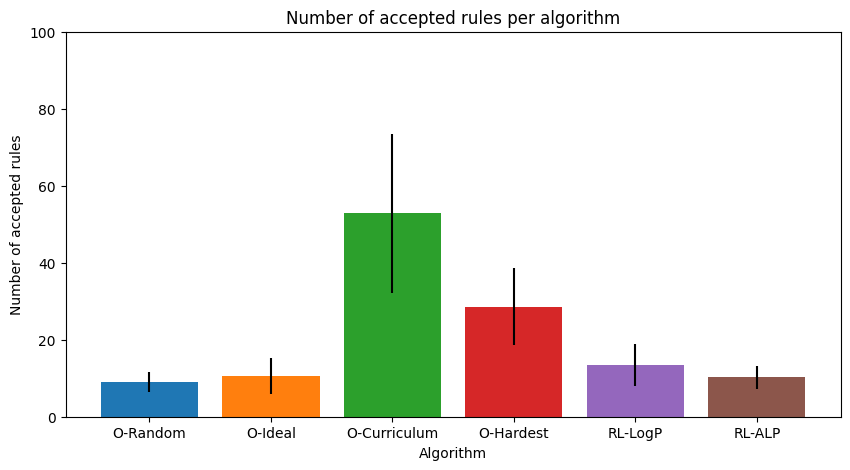

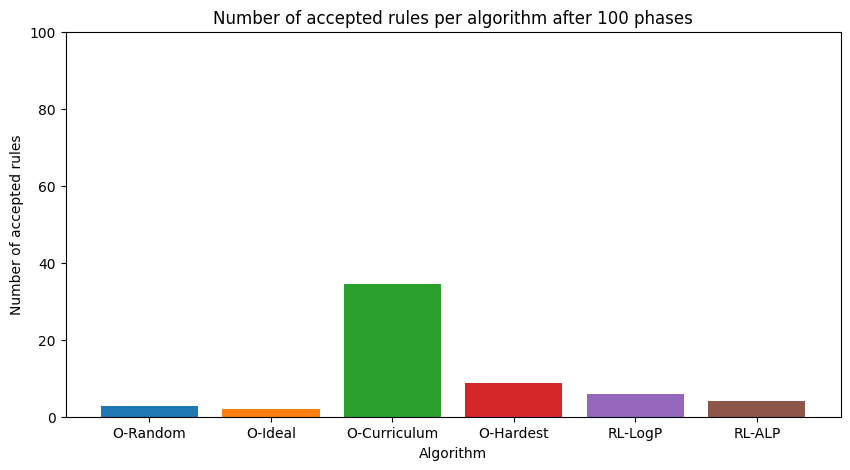

In [9]:

plt.figure(figsize=(10, 5))
for algo_name in all_counter:
    plt.bar(algo_name, np.mean(all_counter[algo_name]), yerr=np.std(all_counter[algo_name]), label=algo_name)
plt.ylim(0, 100)
plt.xlabel("Algorithm")
plt.ylabel("Number of accepted rules")
plt.title("Number of accepted rules per algorithm")
plt.show()

plt.figure(figsize=(10, 5))
for algo_name in all_counter:
    plt.bar(algo_name, np.mean([len([index for index in all_indices[algo_name][seed] if index >=100]) for seed in range(len(all_indices[algo_name]))]), label=algo_name)
plt.ylim(0, 100)
plt.xlabel("Algorithm")
plt.ylabel("Number of accepted rules")
plt.title("Number of accepted rules per algorithm after 100 phases")
plt.show()

In [10]:
for algo in []:
    print(f"# {algo}")
    for incr, rule in enumerate(all_best_rules[algo][:,-1]):
        print(repr(rule)+": "+ str(all_best_likelihoods[algo][incr,-1]))

In [11]:
for algo in []:
    print(f"# {algo}")
    for rule in all_best_rules[algo][:,-1]:
        print(repr(rule)+",")

In [12]:
# Best kept rules of each method
best_taken = 50
all_baselines_name = list(all_likelihoods.keys())
all_best_rules_ind = []
for b_name in all_baselines_name:
    
    best_rules_ind = np.argsort(-all_best_likelihoods[b_name].flatten())[:best_taken]
    all_best_rules_ind.append(best_rules_ind)
likelihoods = np.concatenate([all_best_likelihoods[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
rules = np.concatenate([all_best_rules[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
indices = np.argsort(-likelihoods)
all_colors_start = ["\033[31m", "\033[32m", "\033[34m", "\033[35m", "\033[36m", "\033[37m", "\033[33m", "\033[90m"]
all_colors_end = ["\033[0m"] * len(all_colors_start)
all_colors_names = ["Red", "Green", "Blue", "Magenta", "Cyan", "White", "Yellow", "Bright Black"]
# Print colors for every baselines:
print("Colors for each baselines:")
for incr, b_name in enumerate(all_baselines_name):
    print(f"Baseline: '{b_name}' Color: {all_colors_start[incr]}{all_colors_names[incr]}{all_colors_end[incr]}")
for incr, ind in enumerate(indices):
    color_start = all_colors_start[ind//best_taken]
    color_end = all_colors_end[ind//best_taken]
    print(
        f"{color_start}-----rule-----:{incr}: {repr(rules[ind])}, likelihood: {likelihoods[ind]:2f}{color_end}"
    )

Colors for each baselines:
Baseline: 'O-Random' Color: Red
Baseline: 'O-Ideal' Color: Green
Baseline: 'O-Curriculum' Color: Blue
Baseline: 'O-Hardest' Color: Magenta
Baseline: 'RL-LogP' Color: Cyan
Baseline: 'RL-ALP' Color: White
-----rule-----:0: '1. If the action is \'You go to\' and the object is a seed or gentle creature (cow, elephant, sheep, giraffe, bear, mouse, wolf), predict "You are standing on the [object]."\n2. If you are standing on an animal\'s seed and the action is \'You give the water\', predict "The objects transform into the [animal]."\n3. If the object is a seed or gentle creature (cow, elephant, sheep, giraffe, bear, mouse, or wolf) and the action is \'You give the water\', predict "The objects transform into the [animal]."\n4. If you are standing on the water and the action is \'You pick up\', predict "In your inventory, there is the water."\n5. If you are standing on the water and the action is \'You pick up the object\', predict "In your inventory', likelihood: 

In [13]:
# Number of sames rules per particle
for b_name in all_baselines_name:
    redudant_rules = [len(all_rules[b_name][particle])- len(set(all_rules[b_name][particle])) for particle in range(all_rules[b_name].shape[0])]
    print(f"Number of same rules per particle for {b_name}: {redudant_rules}")

Number of same rules per particle for O-Random: [3, 0, 1, 0, 0, 0, 0, 0]
Number of same rules per particle for O-Ideal: [0, 1, 0, 61, 4, 2, 1, 8]
Number of same rules per particle for O-Curriculum: [157, 55, 27, 237, 13, 43, 135, 102]
Number of same rules per particle for O-Hardest: [125, 294, 140, 19, 299, 93, 29, 417]
Number of same rules per particle for RL-LogP: [0, 2, 0, 1, 0, 0, 0, 0]
Number of same rules per particle for RL-ALP: [0, 0, 0, 0, 0, 0, 0, 0]


## Comparison across seeds

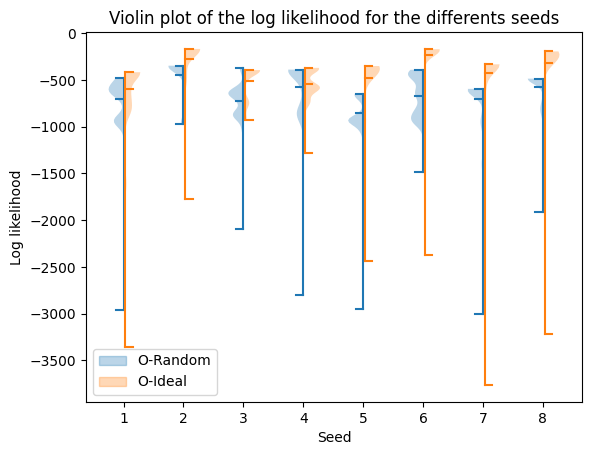

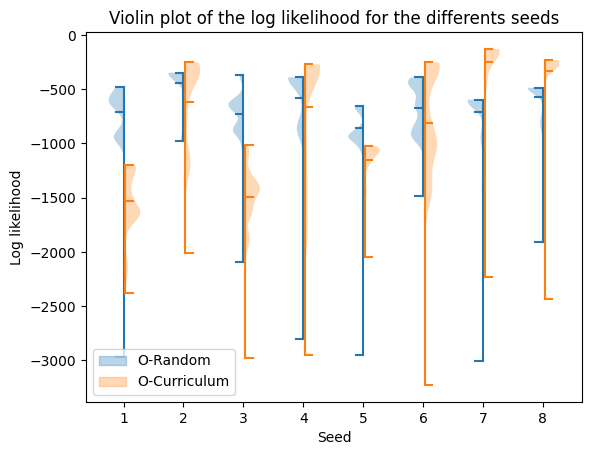

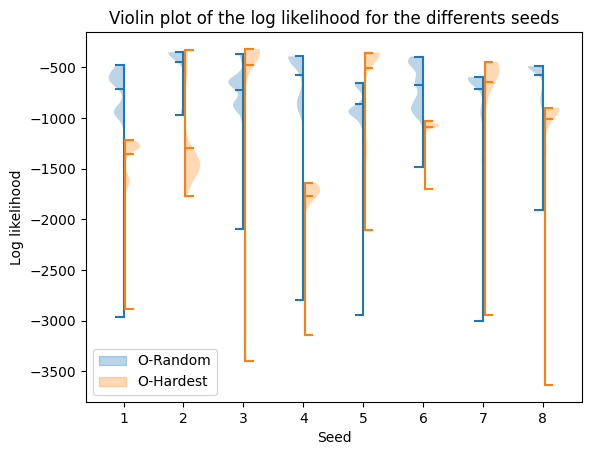

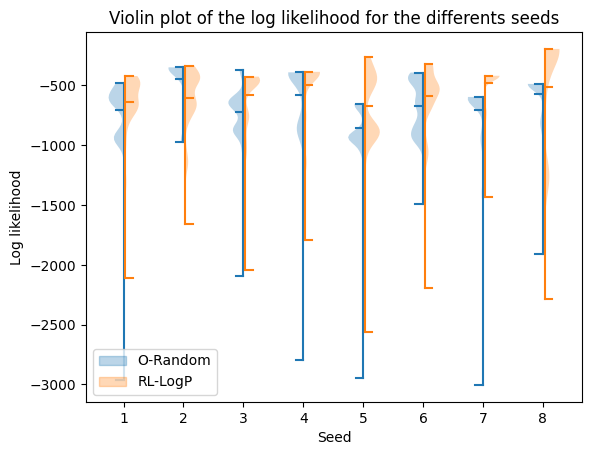

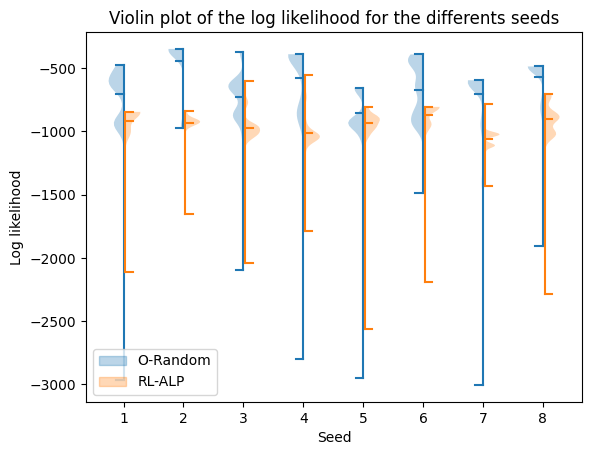

In [14]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
for b_name in all_baselines_name[1:]:
    plt.figure()
    color1 = plt.violinplot(all_best_likelihoods[all_baselines_name[0]].transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
    color1 = matplotlib.patches.Patch(color=color1)
    color2 = plt.violinplot(all_best_likelihoods[b_name].transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_best_likelihoods[b_name]))])["bodies"][0].get_facecolor().flatten()
    color2 = matplotlib.patches.Patch(color=color2)
    plt.legend([color1, color2], [all_baselines_name[0], b_name])
    plt.title("Violin plot of the log likelihood for the differents seeds")
    plt.xlabel("Seed")
    plt.ylabel("Log likelihood")
    plt.show()

## Comparaison collecte de données

In [15]:
for transi_type, value in dict_index_transition.items():
    print(transi_type +": "+ str(len(value)))

Standing: 120
Holding 1: 20
Holding 2: 7
Grow Plant: 12
Grow S.Herbivore: 6
Grow B.Herbivore: 3


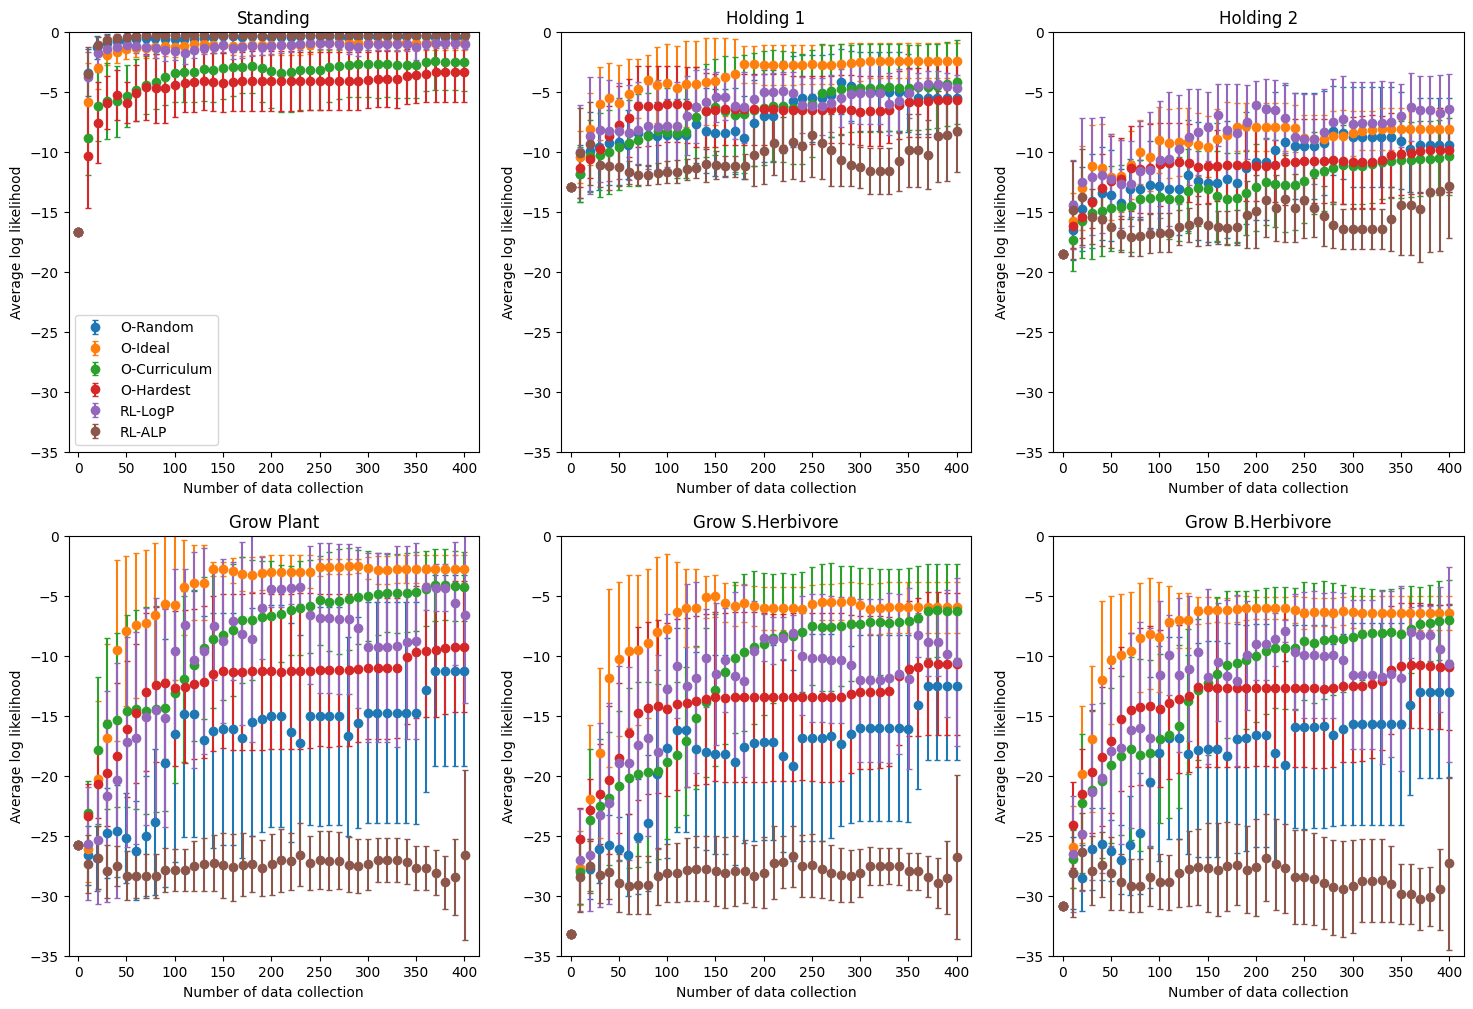

In [16]:
average_size = 10
kernel = np.ones(average_size) / average_size
plt.subplots(2,3, figsize=(18,12))
for incr_tran, transi_type in enumerate(dict_index_transition):
    plt.subplot(2,3, incr_tran+1)

    for incr,b_name in enumerate(all_baselines_name):
        # Get the best rules for each particle and data collection for each traj type
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        
        #Add no rule as first collect:
        _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
        _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[0], axis=0)
        average_mean_ll = np.convolve(_ll_per_transition.mean(axis=0), kernel, mode='valid')[::average_size]
        average_std_ll = np.convolve(_ll_per_transition.std(axis=0), kernel, mode='valid')[::average_size]
        average_median_ll = np.convolve(np.median(_ll_per_transition, axis=0), kernel, mode='valid')[::average_size]
        average_mean_ll = np.insert(average_mean_ll,0, _norule_likelihood_transition.mean(axis=0), axis=0)
        average_std_ll = np.insert(average_std_ll,0, _norule_likelihood_transition.std(axis=0), axis=0)
        average_median_ll = np.insert(average_median_ll,0, np.median(_norule_likelihood_transition, axis=0), axis=0)
        #Plot
        # plt.plot(average_size*np.arange(len(average_median_ll))+ incr*0.05, average_median_ll, label=b_name)
        plt.errorbar(average_size*np.arange(len(average_mean_ll))+ incr*0.05, average_mean_ll, yerr=average_std_ll, label=b_name, capsize=2, fmt='o')
        plt.ylim(-35, 0)
        plt.xlim(-10, 415)
    # plt.hlines(y=_norule_likelihood_transition.mean(axis=0), xmin=0, xmax=405, color='black', linestyle='--', label="No rule")
    plt.xlabel("Number of data collection")
    plt.ylabel("Average log likelihood")
    plt.title(f"{transi_type}")
plt.subplot(2,3, 1)
plt.legend()
plt.show()

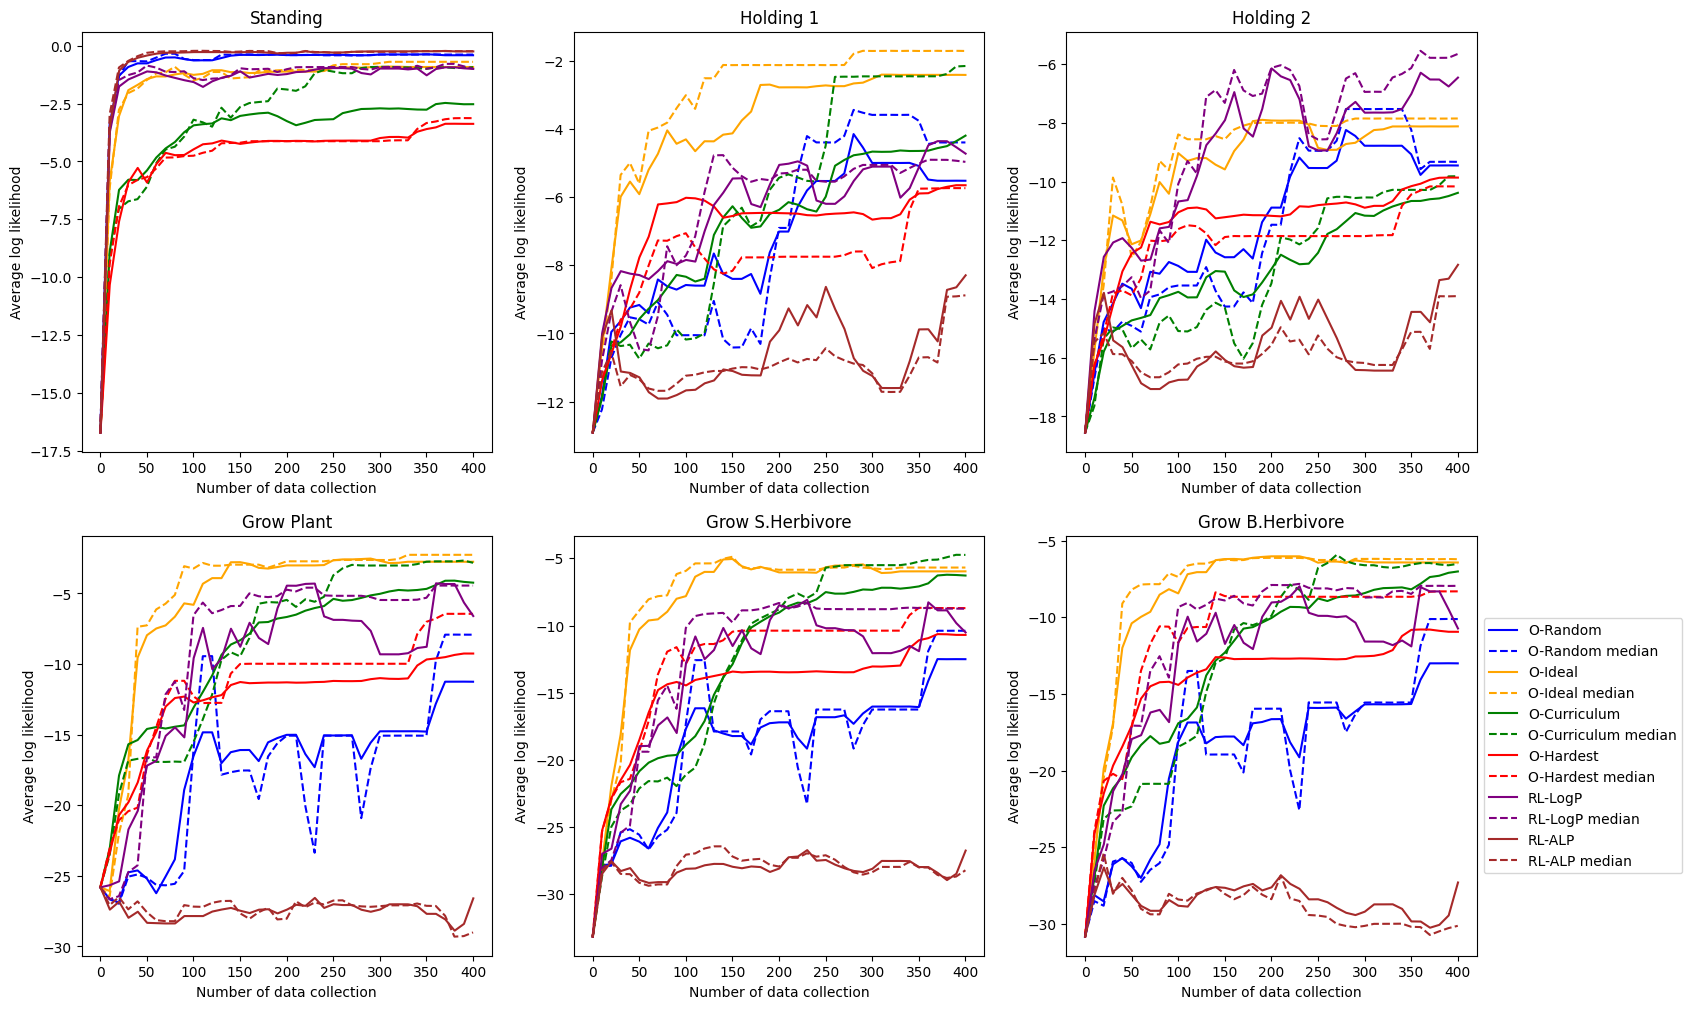

In [17]:
average_size = 10
kernel = np.ones(average_size) / average_size
plt.subplots(2,3, figsize=(18,12))
for incr_tran, transi_type in enumerate(dict_index_transition):
    plt.subplot(2,3, incr_tran+1)
    colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]

    for incr,b_name in enumerate(all_baselines_name):
        # Get the best rules for each particle and data collection for each traj type
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        
        #Add no rule as first collect:
        _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
        _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[0], axis=0)
        average_mean_ll = np.convolve(_ll_per_transition.mean(axis=0), kernel, mode='valid')[::average_size]
        average_std_ll = np.convolve(_ll_per_transition.std(axis=0), kernel, mode='valid')[::average_size]
        average_median_ll = np.convolve(np.median(_ll_per_transition, axis=0), kernel, mode='valid')[::average_size]
        average_mean_ll = np.insert(average_mean_ll,0, _norule_likelihood_transition.mean(axis=0), axis=0)
        average_std_ll = np.insert(average_std_ll,0, _norule_likelihood_transition.std(axis=0), axis=0)
        average_median_ll = np.insert(average_median_ll,0, np.median(_norule_likelihood_transition, axis=0), axis=0)
        #Plot
        plt.plot(average_size*np.arange(len(average_mean_ll))+ incr*0.05, average_mean_ll, label=b_name, color=colors[incr])
        plt.plot(average_size*np.arange(len(average_median_ll)), average_median_ll, label=b_name+" median", linestyle='--', color=colors[incr])
    plt.xlabel("Number of data collection")
    plt.ylabel("Average log likelihood")
    plt.title(f"{transi_type}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

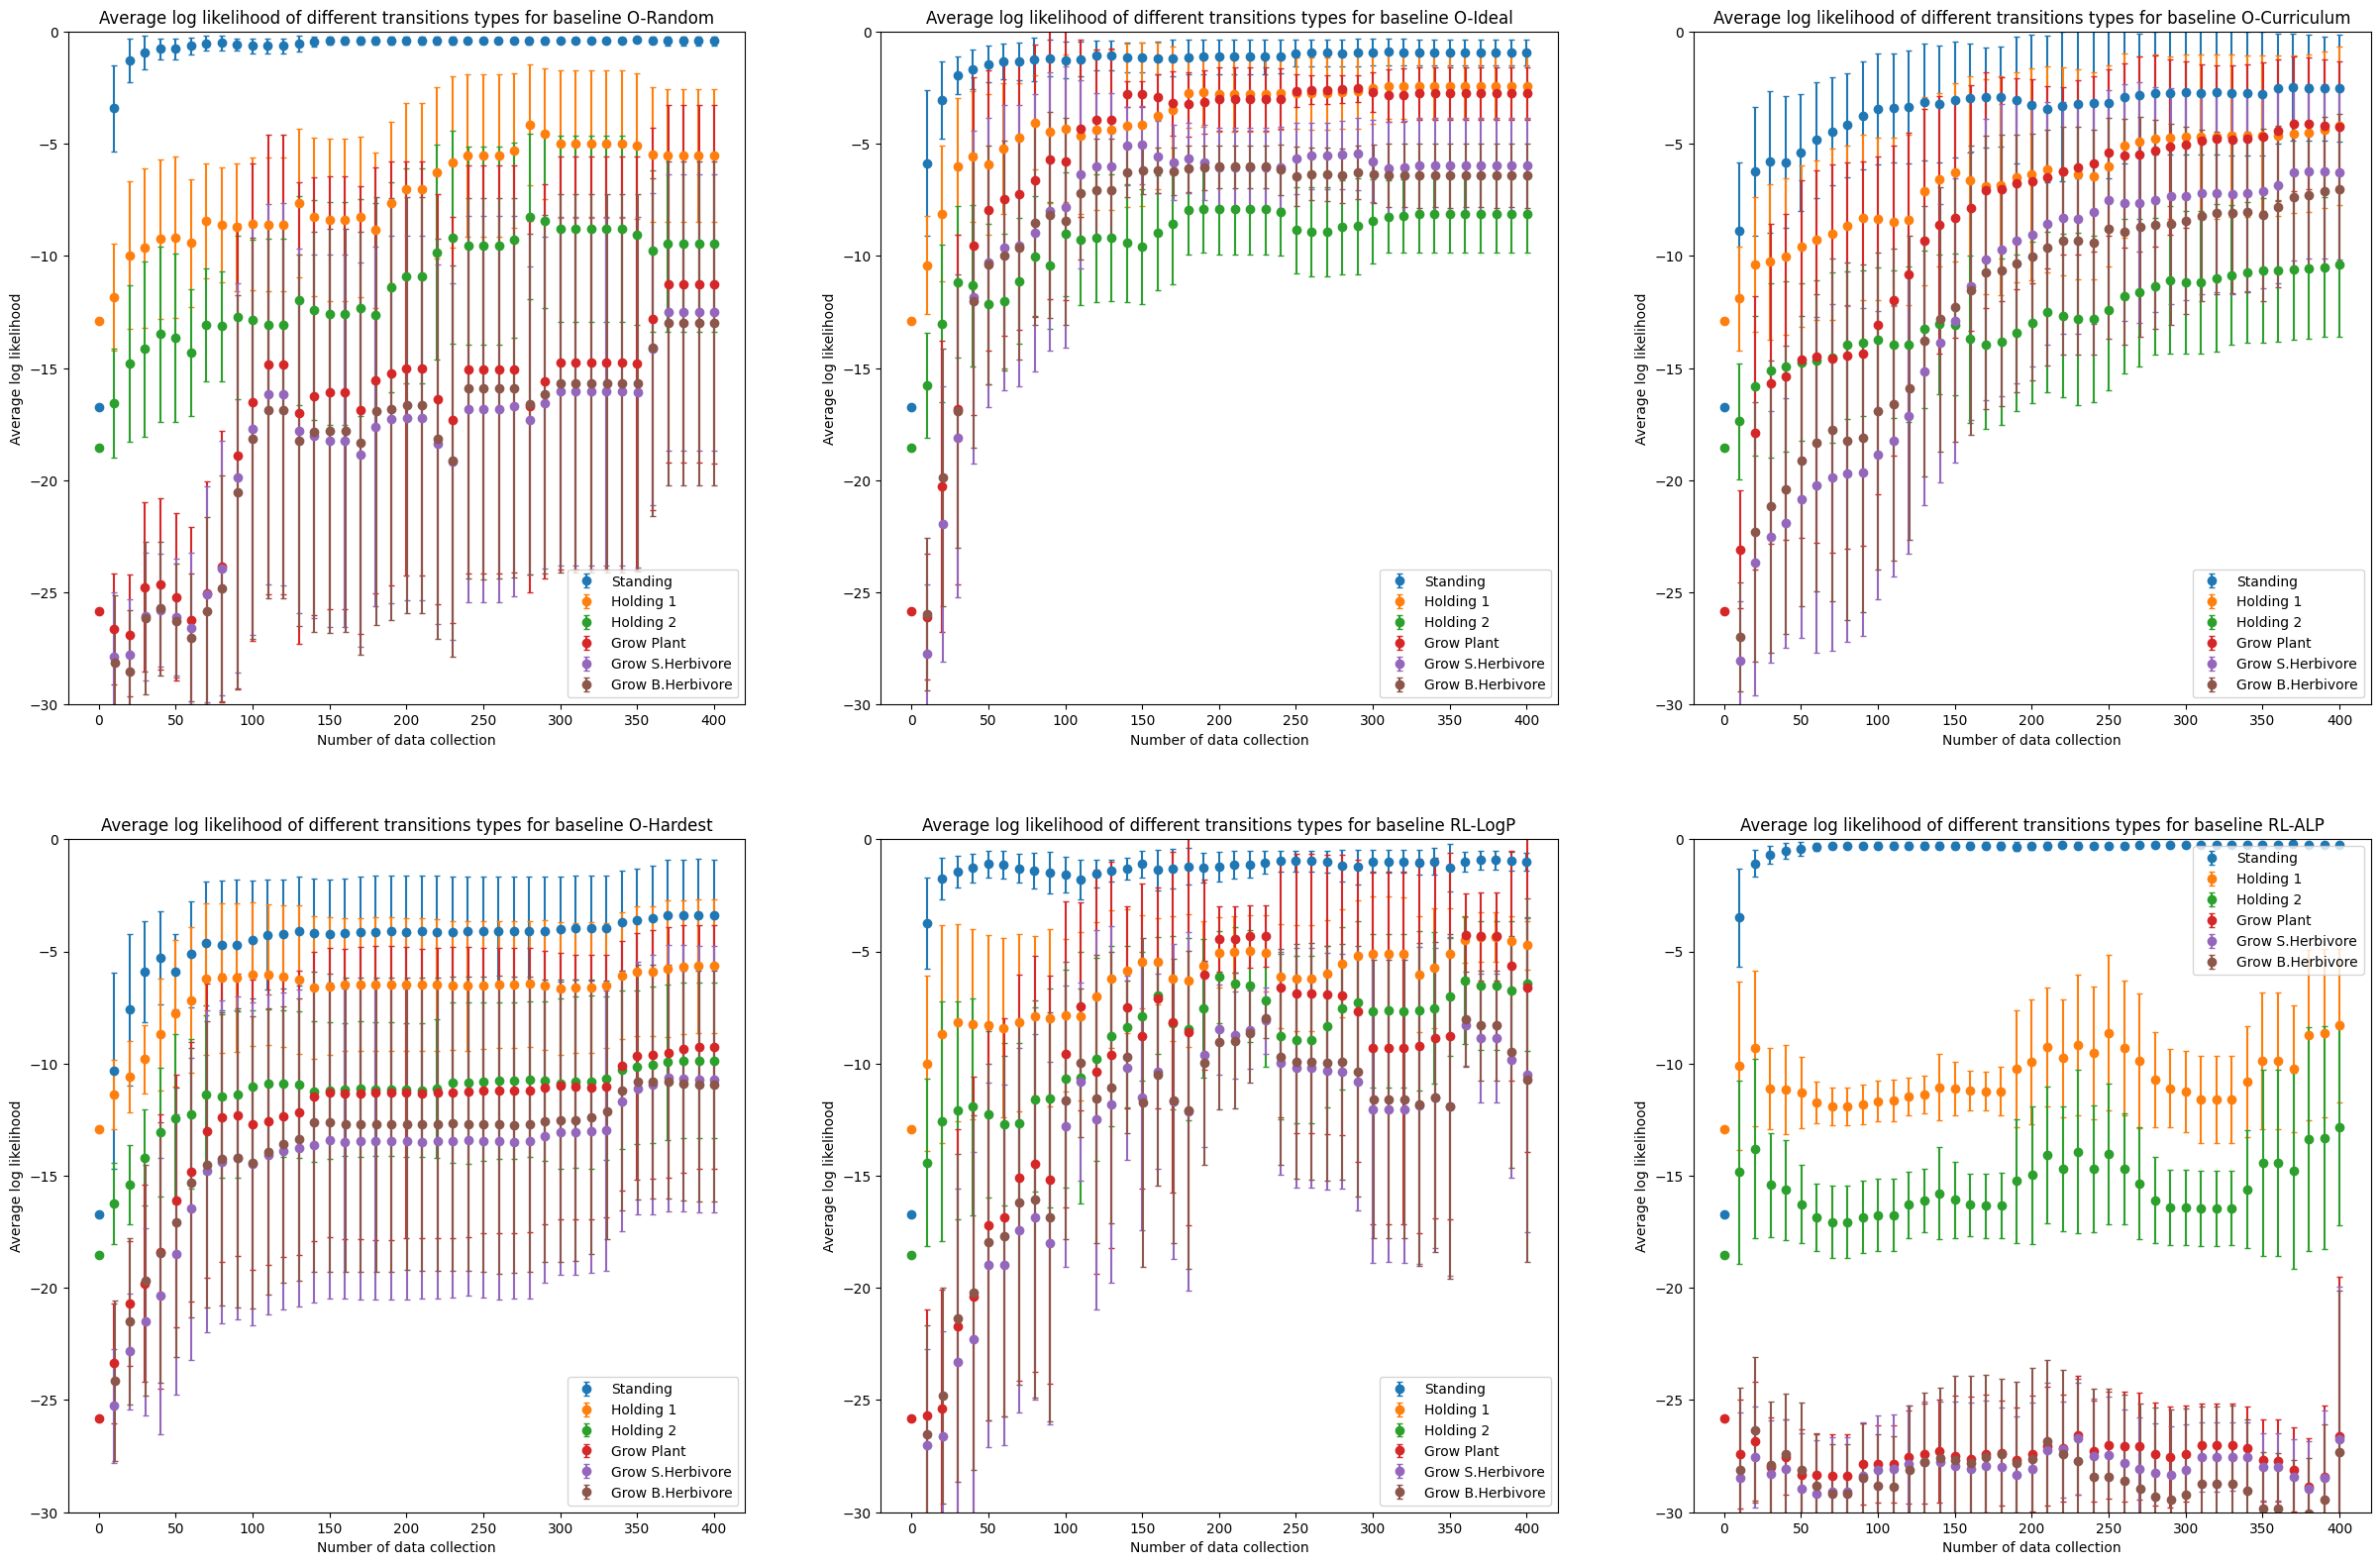

In [18]:
average_size = 10
kernel = np.ones(average_size) / average_size
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
for incr_m, b_name in enumerate(all_baselines_name):
    plt.subplot(3,3,incr_m+1)
    for incr, transi_type in enumerate(dict_index_transition):
        # Get the best rules for each particle and data collection for each traj type
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        
        #Add no rule as first collect:
        _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
        _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[0], axis=0)
        average_mean_ll = np.convolve(_ll_per_transition.mean(axis=0), kernel, mode='valid')[::average_size]
        average_std_ll = np.convolve(_ll_per_transition.std(axis=0), kernel, mode='valid')[::average_size]
        average_mean_ll = np.insert(average_mean_ll,0, _norule_likelihood_transition.mean(axis=0), axis=0)
        average_std_ll = np.insert(average_std_ll,0, _norule_likelihood_transition.std(axis=0), axis=0)
        #Plot
        plt.errorbar(average_size*np.arange(len(average_mean_ll))+ incr*0.05, average_mean_ll, yerr=average_std_ll, label=transi_type, capsize=2, fmt='o')
    
    plt.legend()
    plt.xlabel("Number of data collection")
    plt.ylim((-30,0))
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for baseline {b_name}")


## Likelihood as a function of collected transition

In [18]:
_norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
# Build cumulative count for each seed and transition
cumul_transition = {algo_name:{k: np.zeros(all_used_transitions[algo_name].shape) for k in dict_index_transition.keys()} for algo_name in all_used_transitions}
ll_per_transition = {algo_name:{transi_type: all_best_transition_ll[algo_name][:,:,dict_index_transition[transi_type]].mean(axis=-1) for transi_type in dict_index_transition} for algo_name in all_used_transitions}
for algo_name in all_used_transitions:
    for i_seed, used_transitions_per_seed in enumerate(all_used_transitions[algo_name]):
        for i_data_collect, used_transitions_per_collect in enumerate(used_transitions_per_seed):
            for transition_type in dict_index_transition:
                cumul_transition[algo_name][transition_type][i_seed, i_data_collect] = cumul_transition[algo_name][transition_type][i_seed, i_data_collect-1] + used_transitions_per_collect.get(transition_type, 0)
                

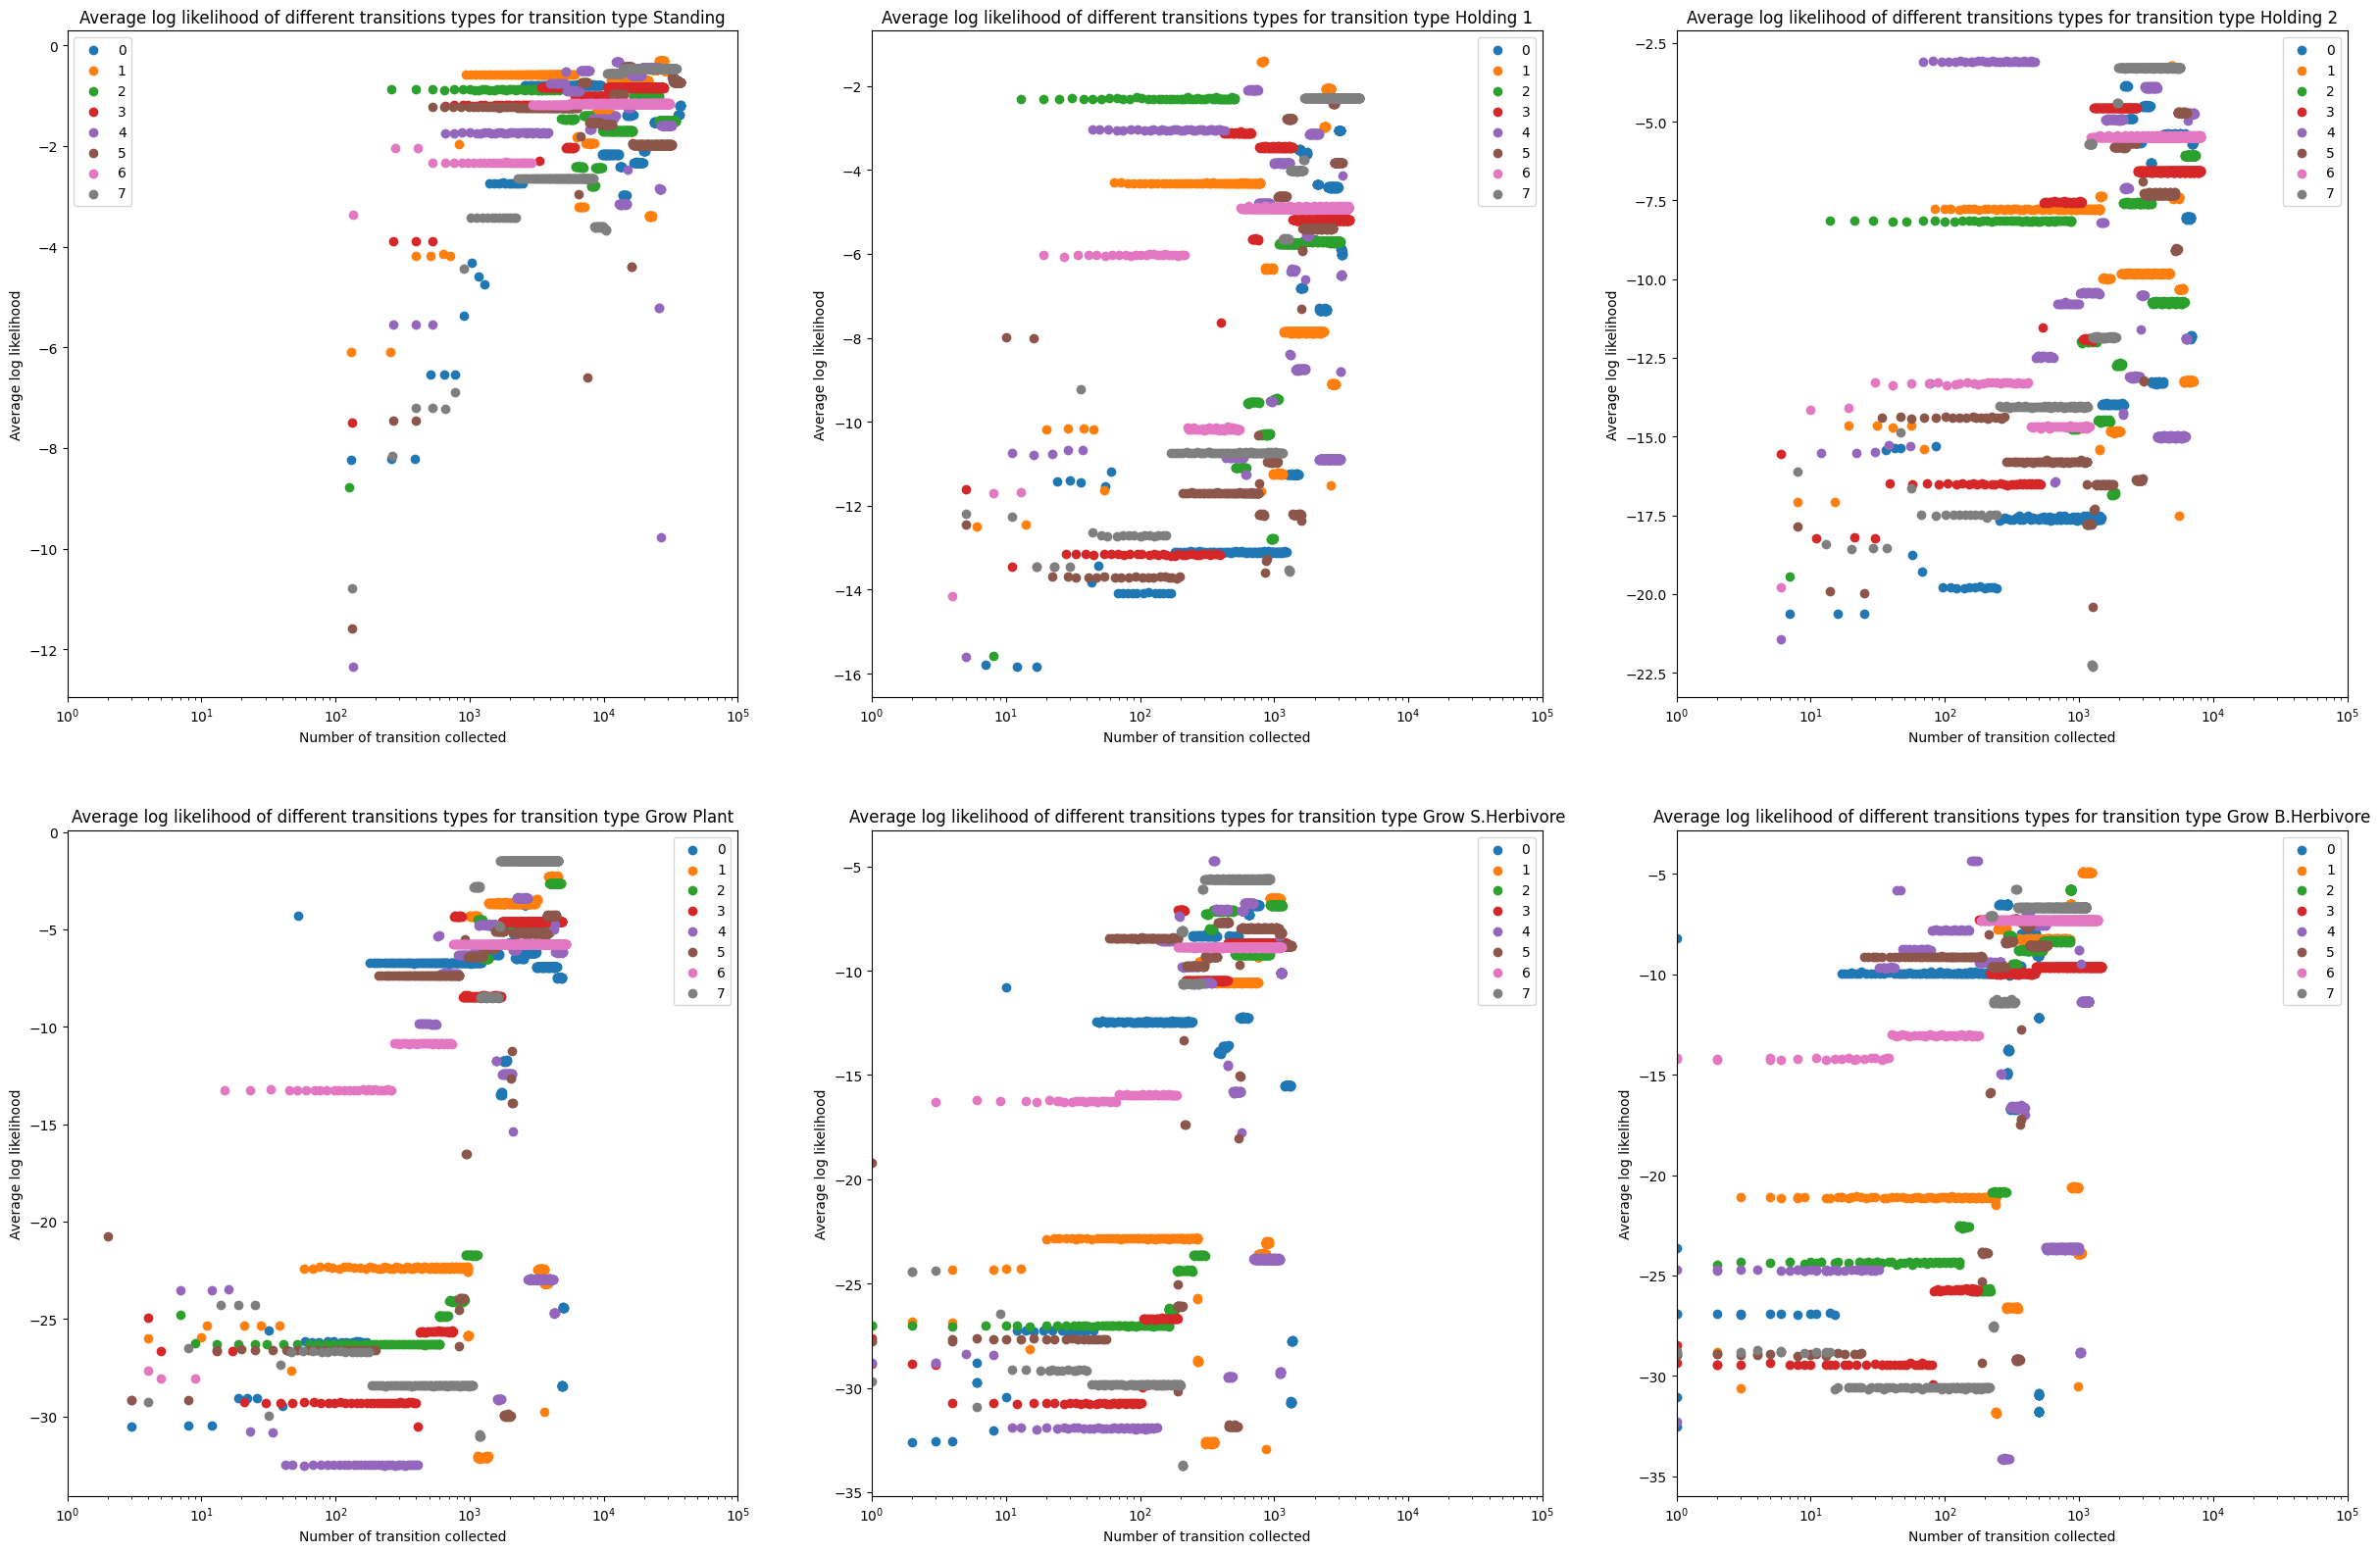

In [19]:
# Scatter plot for each transtion type for specific algo
algo_name = "RL-LogP"

plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
for i_tt, transition_type in enumerate(cumul_transition[algo_name]):
    plt.subplot(3,3,i_tt+1)
    for seed in range(cumul_transition[algo_name][transition_type].shape[0]):
        plt.scatter(cumul_transition[algo_name][transition_type][seed], ll_per_transition[algo_name][transition_type][seed], label=seed)
        plt.xlim(1, 10**5)
        plt.xscale("log")
        # plt.yscale("log")
    plt.legend()
    plt.xlabel("Number of transition collected")
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for transition type {transition_type}")

/tmp/ipykernel_60715/1165349355.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


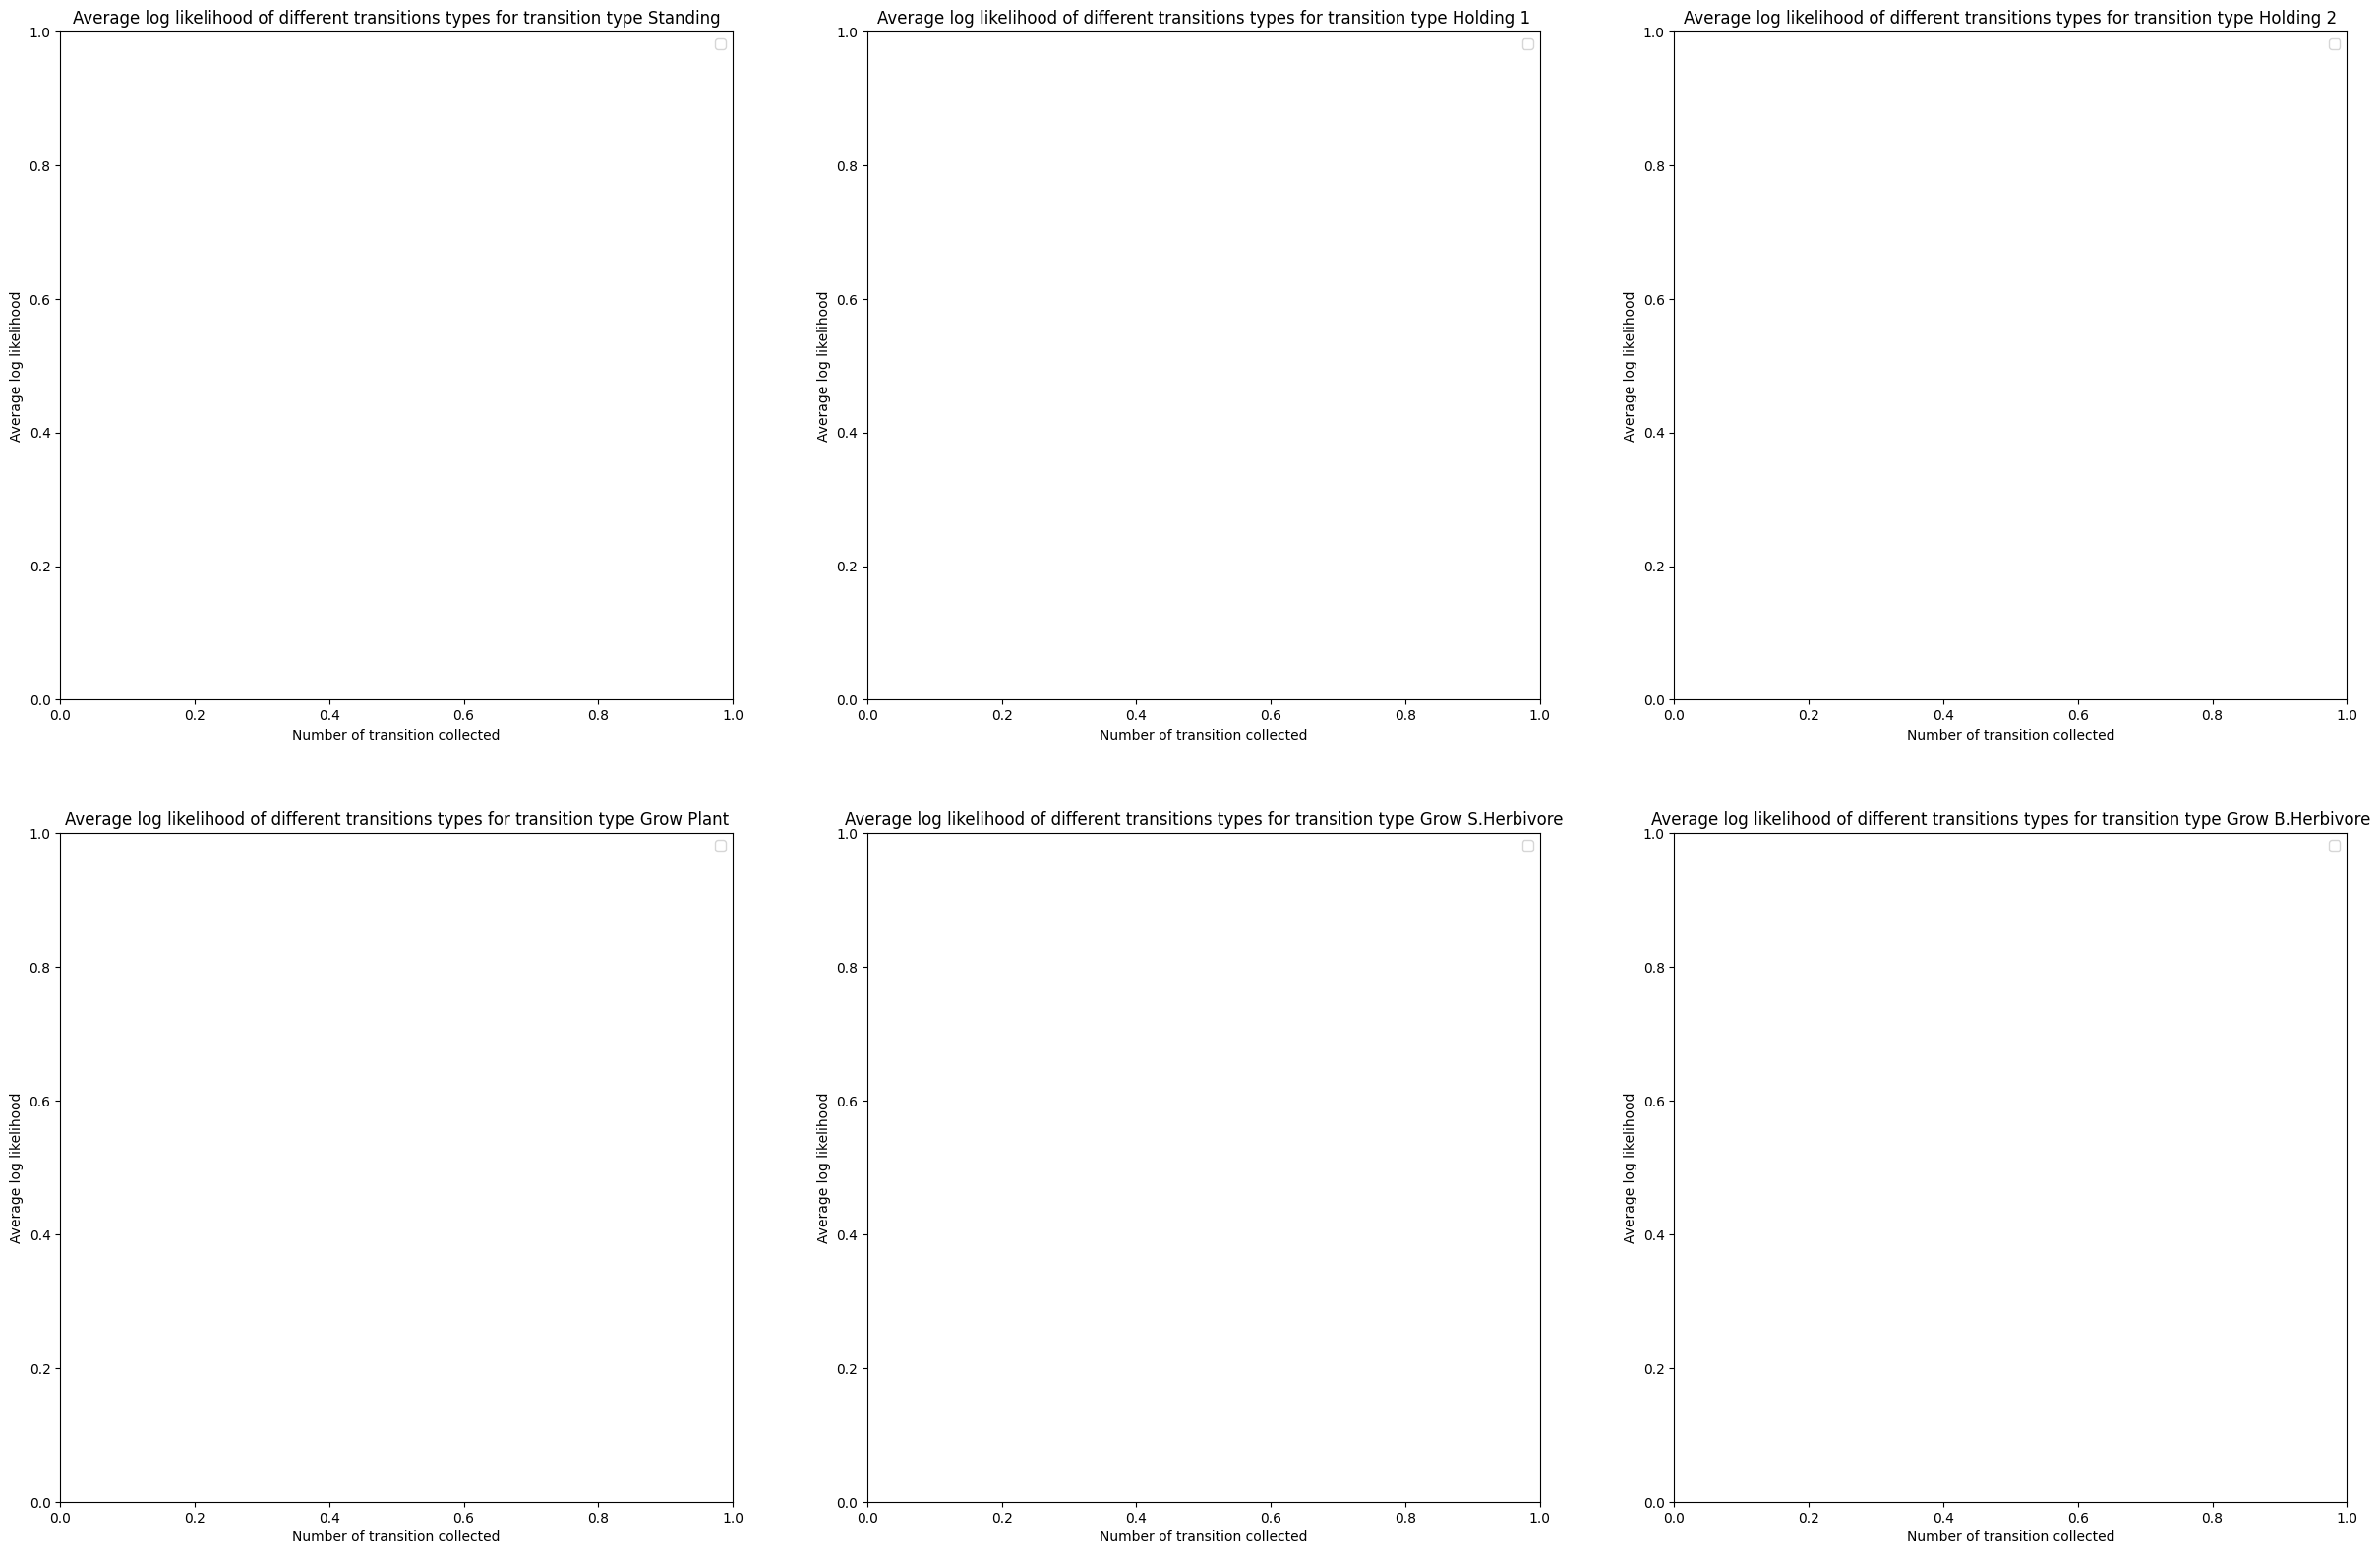

In [20]:
# Scatter plot for each transtion type
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
for i_tt, transition_type in enumerate(dict_index_transition):
    plt.subplot(3,3,i_tt+1)
    for algo_name in []:
        plt.scatter(cumul_transition[algo_name][transition_type].flatten(), ll_per_transition[algo_name][transition_type].flatten(), label=algo_name)
        plt.xlim(1, 10**5)
        plt.xscale("log")
    plt.legend()
    plt.xlabel("Number of transition collected")
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for transition type {transition_type}")


/tmp/ipykernel_60715/2474462173.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


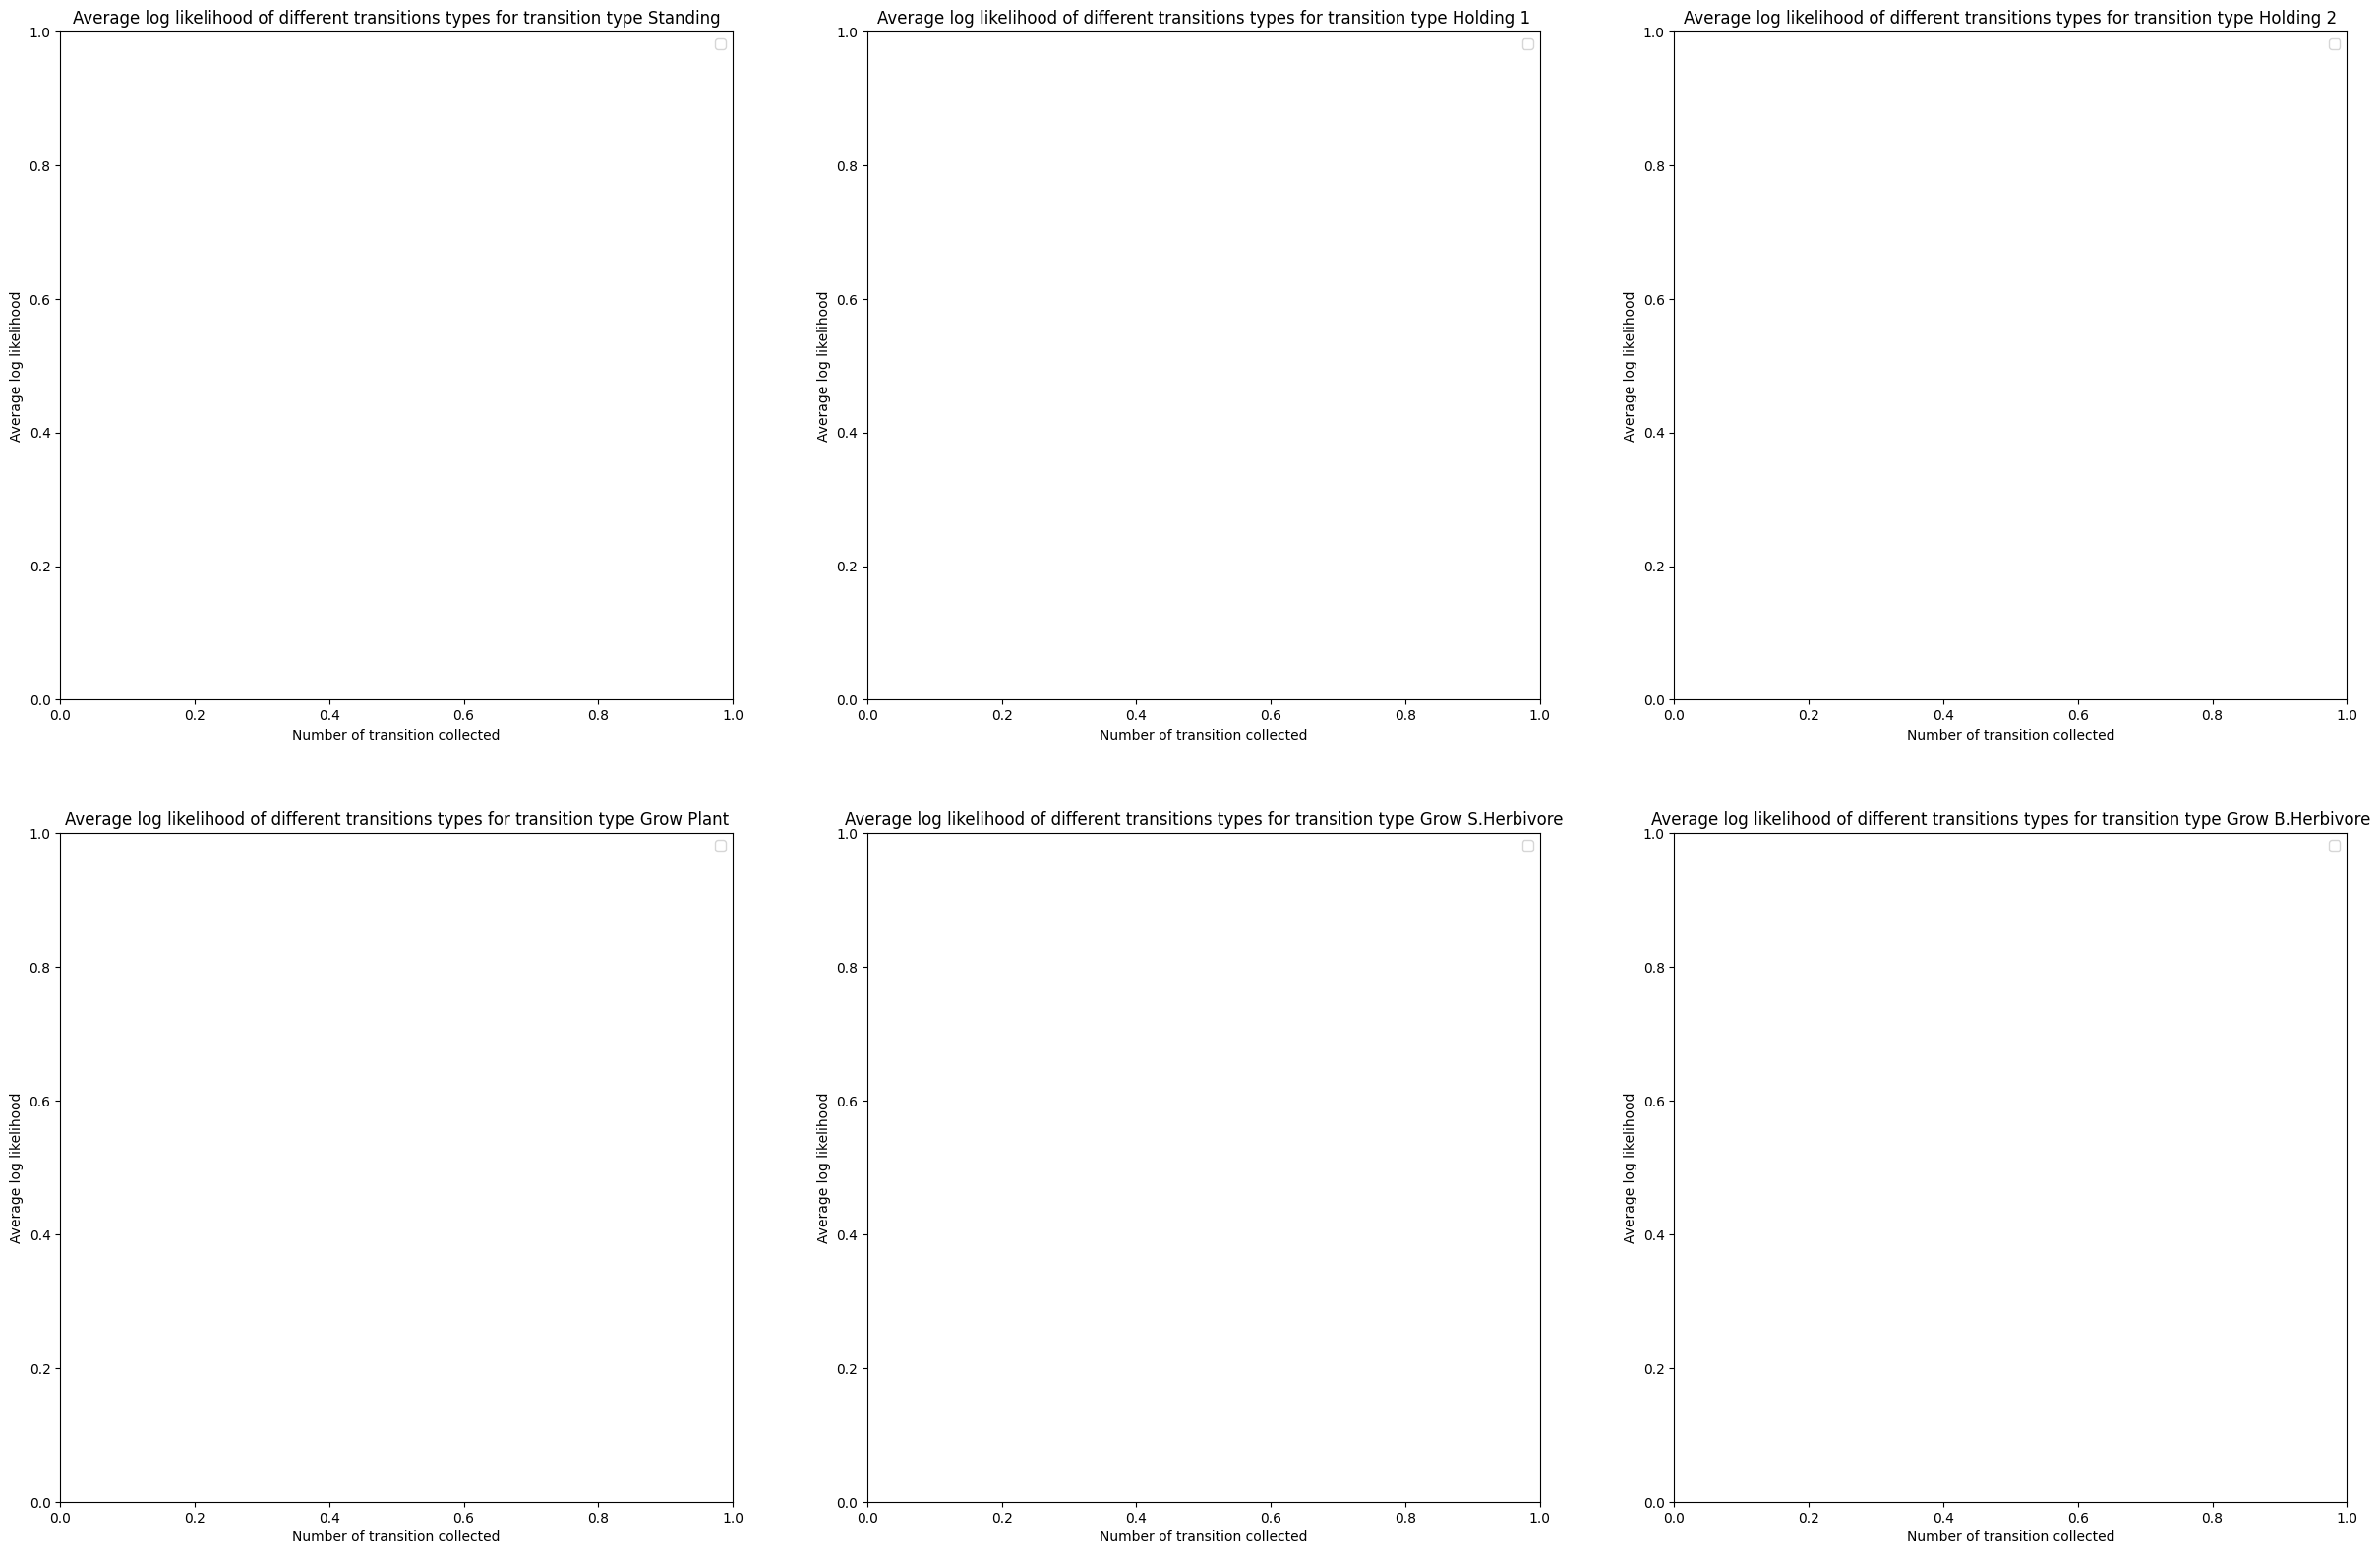

In [21]:
# Scatter plot for each transtion type
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
for i_tt, transition_type in enumerate(dict_index_transition):
    plt.subplot(3,3,i_tt+1)
    for algo_name in []:
        plt.scatter((cumul_transition[algo_name][transition_type]/cumul_transition[algo_name][transition_type][:,-1:]).flatten(), ll_per_transition[algo_name][transition_type].flatten(), label=algo_name)
        plt.xscale("log")
    plt.legend()
    plt.xlabel("Number of transition collected")
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for transition type {transition_type}")


/tmp/ipykernel_60715/389985113.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


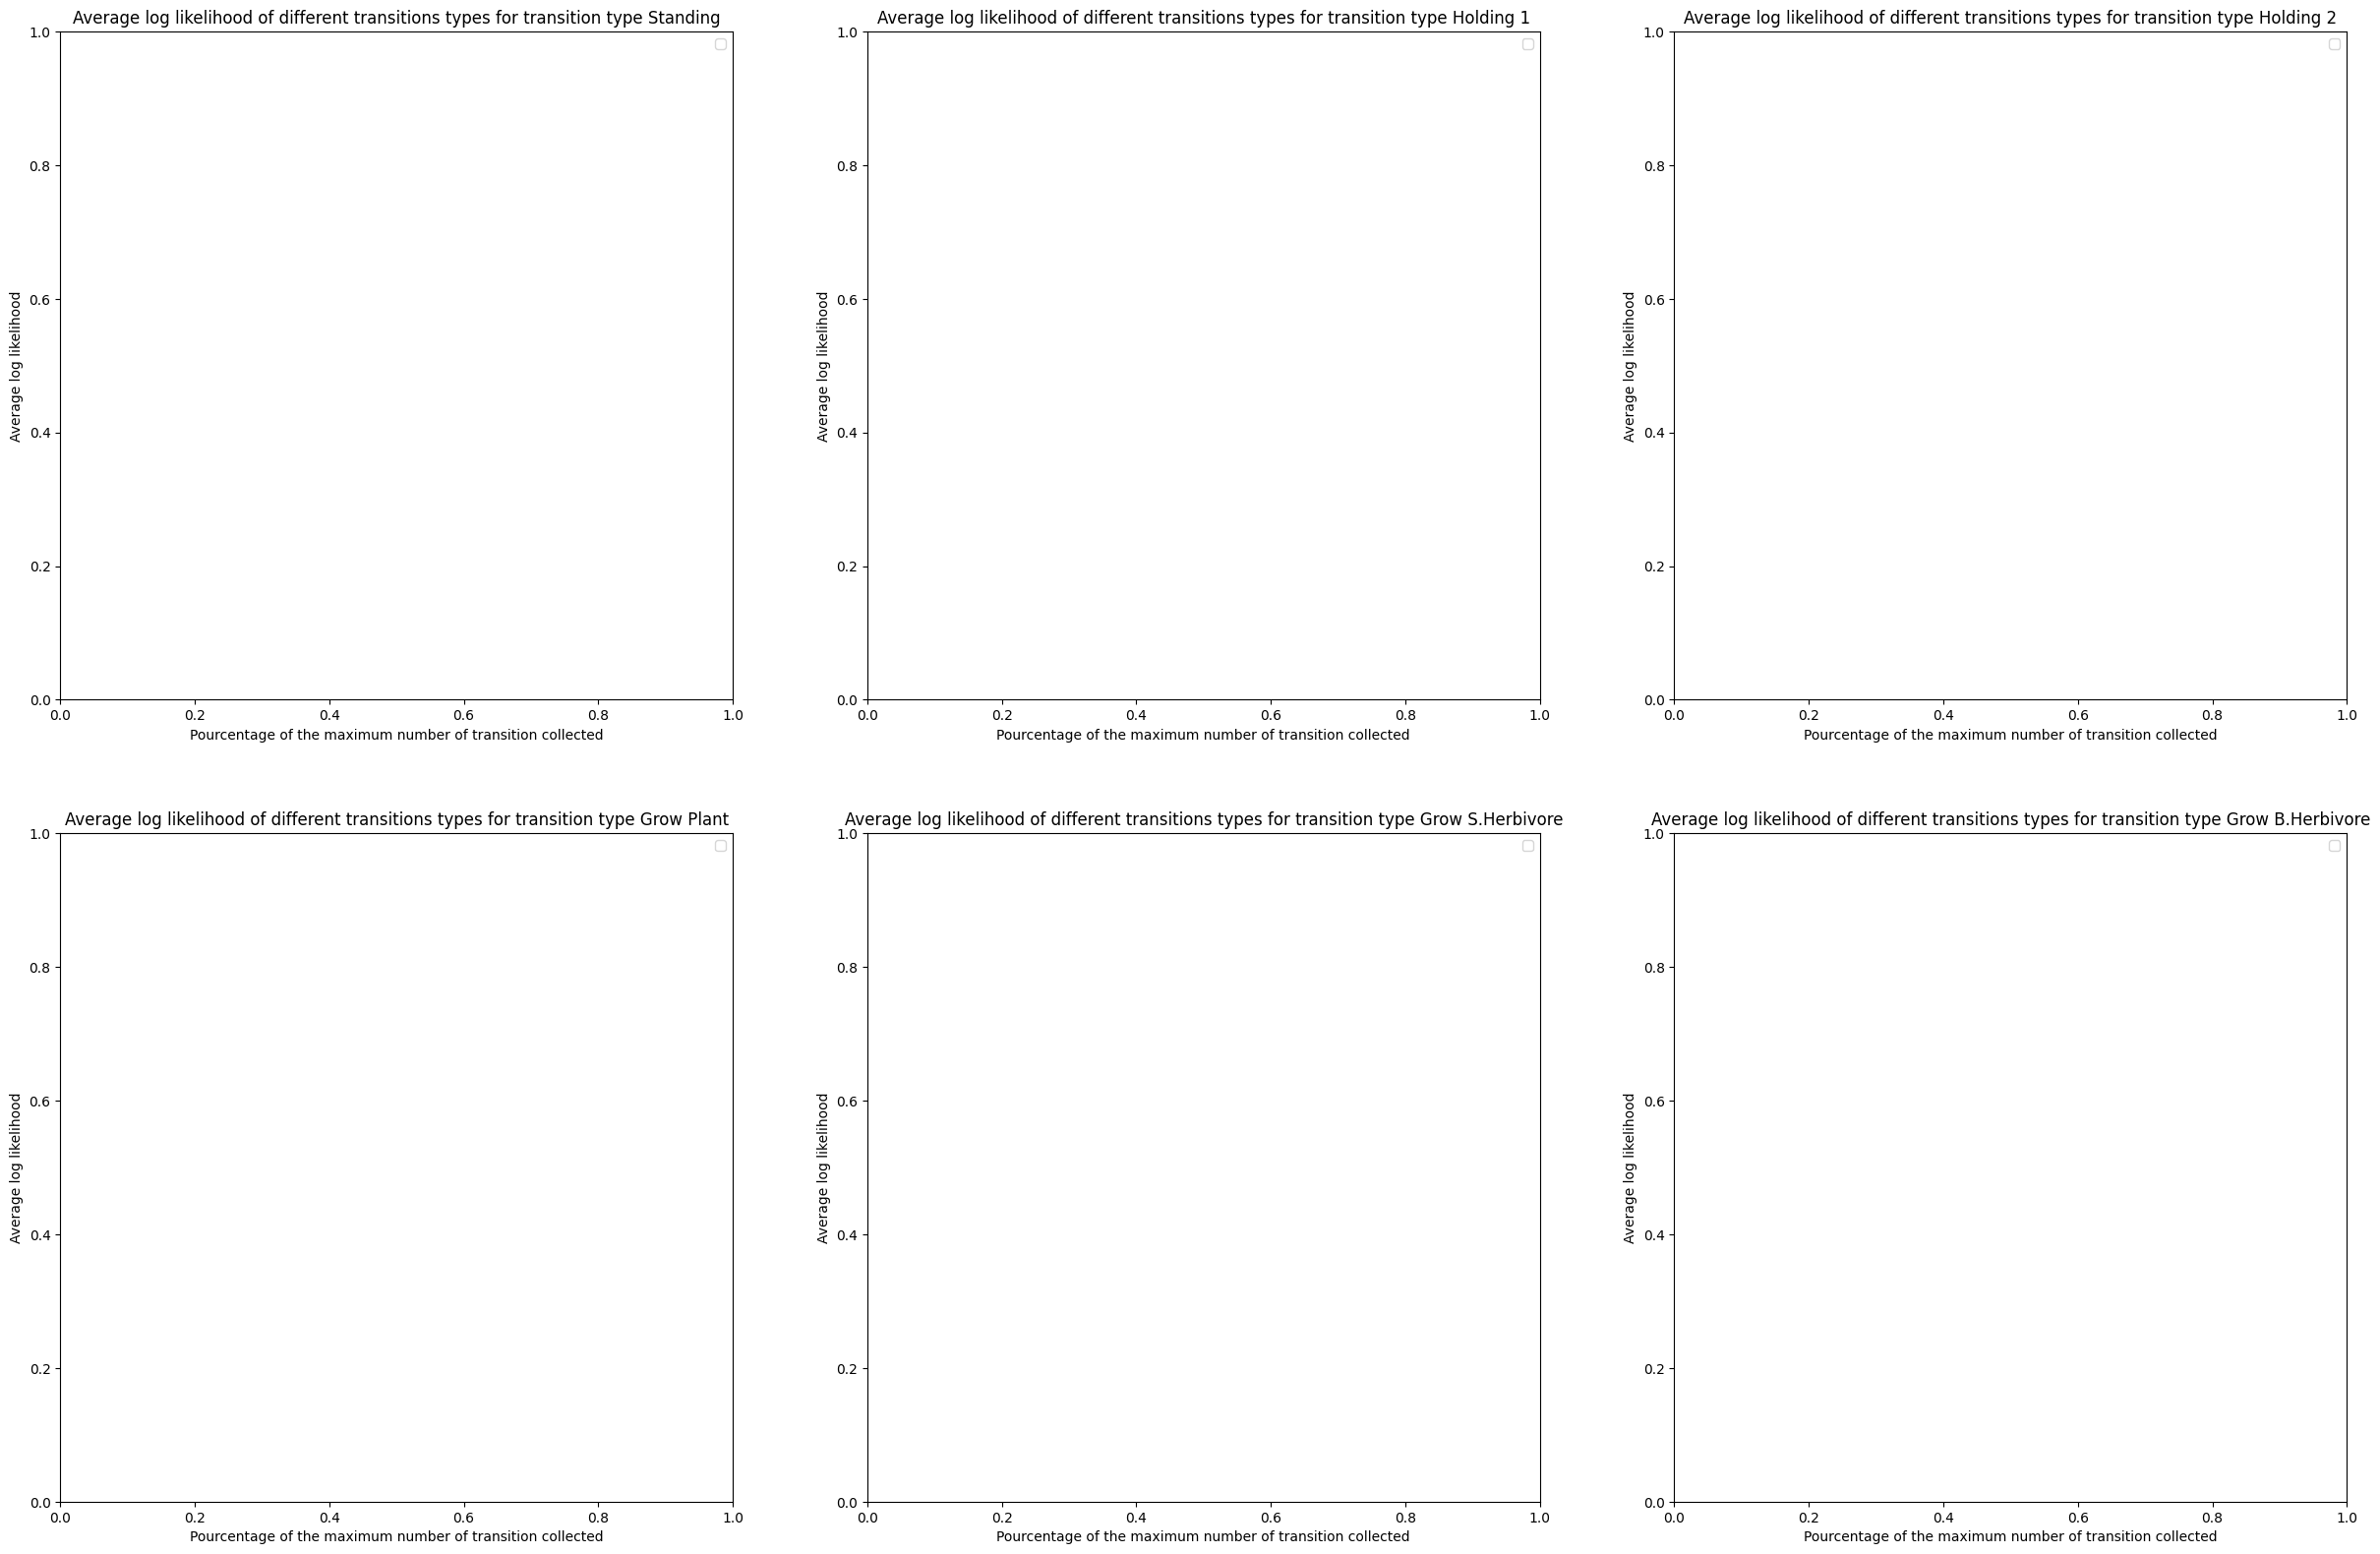

In [22]:
# Scatter plot for each transtion type
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
_seed=2
for i_tt, transition_type in enumerate(dict_index_transition):
    plt.subplot(3,3,i_tt+1)
    for algo_name in []:
        plt.scatter((cumul_transition[algo_name][transition_type]/cumul_transition[algo_name][transition_type][:,-1:])[_seed], ll_per_transition[algo_name][transition_type][_seed].flatten(), label=algo_name)
    plt.legend()
    plt.xlabel("Pourcentage of the maximum number of transition collected")
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for transition type {transition_type}")


## Proportion of collected transition as a function of steps

In [61]:
#Plot the collected transitions per episode for a specific algorithm
algo_name = "RL-ALP"
#Get all transitions per episode
transitions_per_episode_per_transition = {}
for transition_type in dict_index_transition:
    transitions_per_episode_per_transition[transition_type] = []
    for seed in range(all_used_transitions[algo_name].shape[0]):
        all_values = []
        for step in range(all_used_transitions[algo_name].shape[1]):
            all_values.append(all_used_transitions[algo_name][seed, step].get(transition_type, 0))
        transitions_per_episode_per_transition[transition_type].append(all_values)
    transitions_per_episode_per_transition[transition_type] = np.array(transitions_per_episode_per_transition[transition_type])

In [62]:
#Fuse Holding 1 and Holding 2
transitions_per_episode_per_transition["Holdings"] = transitions_per_episode_per_transition["Holding 1"] + transitions_per_episode_per_transition["Holding 2"]
del transitions_per_episode_per_transition["Holding 1"]
del transitions_per_episode_per_transition["Holding 2"]

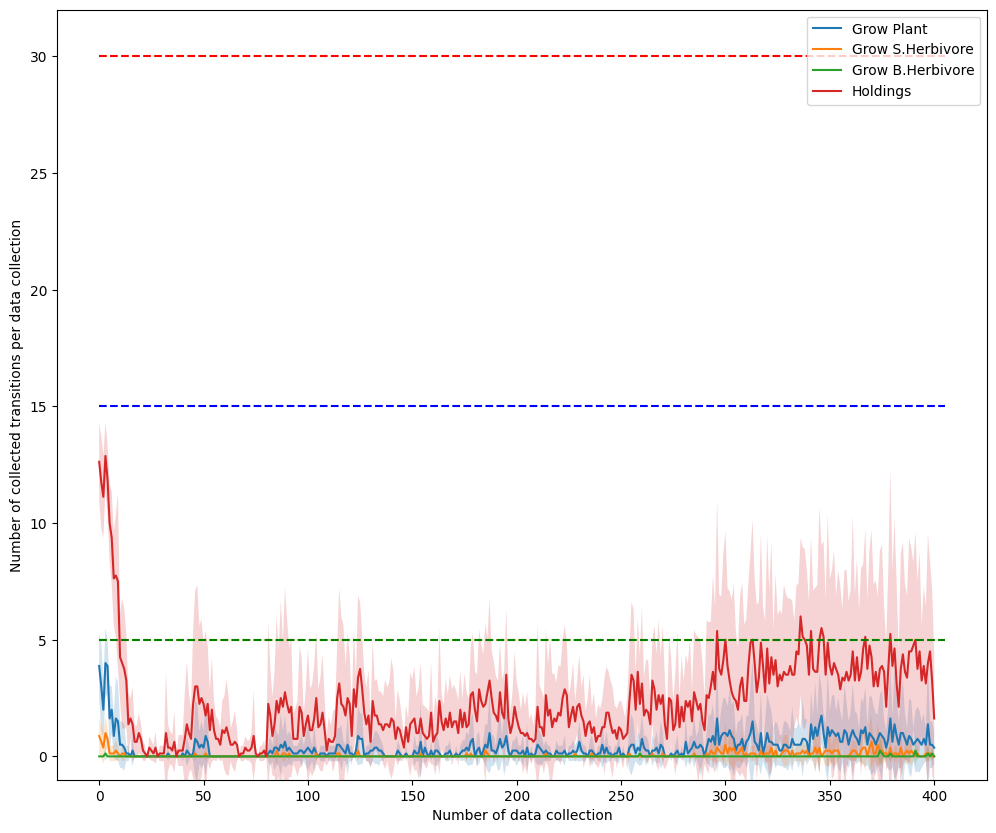

In [63]:

#Plot the transitions per episode
plt.figure(figsize=(12,10))
for key, value in transitions_per_episode_per_transition.items():
    if key == "Standing":
        continue
    x = np.arange(value.shape[1])
    y = value.mean(axis=0)
    yerr= value.std(axis=0)
    plt.plot(x,y, label=key)
    plt.fill_between(x, y-yerr, y+yerr, alpha=0.2)
plt.xlabel("Number of data collection")
plt.ylabel("Number of collected transitions per data collection")
plt.hlines([15,5,5,30], xmin=0, xmax=405, color=["blue", "orange", "green", "red"], linestyle='--', label=None)
plt.ylim(-1,32)
# plt.ylim(0,5)
plt.legend()
plt.show()

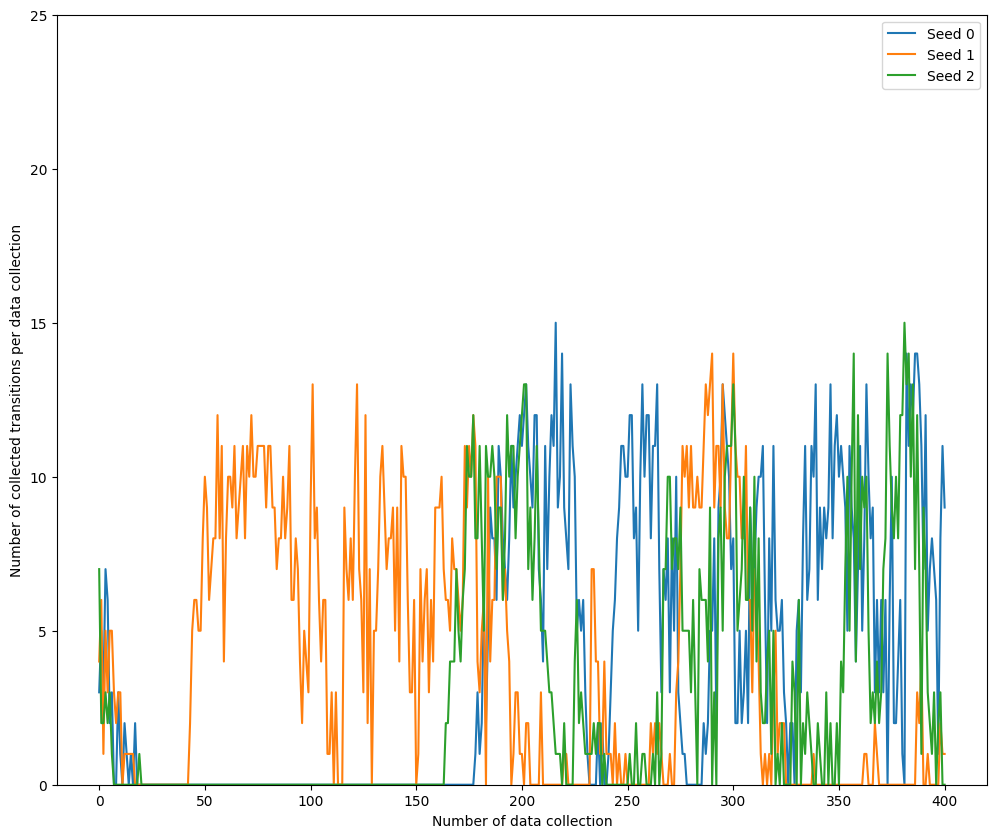

In [16]:
#For specific transition
transition_type = "transformP"
seed = 0
plt.figure(figsize=(12,10))
x = np.arange(transitions_per_episode_per_transition[transition_type].shape[1])
y = transitions_per_episode_per_transition[transition_type]
for seed in range(3):
    plt.plot(x,y[seed], label=f"Seed {seed}")
plt.ylim(0,25)
plt.xlabel("Number of data collection")
plt.ylabel("Number of collected transitions per data collection")
# plt.ylim(0,5)
plt.legend()
plt.show()

In [29]:
# Best kept rules of each method
best_taken = 50
all_baselines_name = list(all_likelihoods.keys())
all_best_rules_ind = []
for b_name in all_baselines_name:
    
    best_rules_ind = np.argsort(-all_best_likelihoods[b_name].flatten())[:best_taken]
    all_best_rules_ind.append(best_rules_ind)
likelihoods = np.concatenate([all_best_likelihoods[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
rules = np.concatenate([all_best_rules[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
indices = np.argsort(-likelihoods)
all_colors_start = ["\033[31m", "\033[32m", "\033[34m", "\033[35m", "\033[36m", "\033[37m", "\033[33m", "\033[90m"]
all_colors_end = ["\033[0m"] * len(all_colors_start)
all_colors_names = ["Red", "Green", "Blue", "Magenta", "Cyan", "White", "Yellow", "Bright Black"]
# Print colors for every baselines:
print("Colors for each baselines:")
for incr, b_name in enumerate(all_baselines_name):
    print(f"Baseline: '{b_name}' Color: {all_colors_start[incr]}{all_colors_names[incr]}{all_colors_end[incr]}")
for incr, ind in enumerate(indices):
    color_start = all_colors_start[ind//best_taken]
    color_end = all_colors_end[ind//best_taken]
    print(
        f"{color_start}-----rule-----:{incr}: {repr(rules[ind])}, likelihood: {likelihoods[ind]:2f}{color_end}"
    )

Colors for each baselines:
Baseline: 'PB' Color: Red
Baseline: 'CP' Color: Green
Baseline: 'RB' Color: Blue
Baseline: 'DB' Color: Magenta
Baseline: 'LL' Color: Cyan
Baseline: 'ALP' Color: White
Baseline: 'ALPEXP' Color: Yellow
-----rule-----:0: '1. If the action is \'You go to\' and the object is a seed or gentle creature (cow, elephant, sheep, giraffe, bear, mouse, wolf), predict "You are standing on the [object]."\n2. If you are standing on an animal\'s seed and the action is \'You give the water\', predict "The objects transform into the [animal]."\n3. If the object is a seed or gentle creature (cow, elephant, sheep, giraffe, bear, mouse, or wolf) and the action is \'You give the water\', predict "The objects transform into the [animal]."\n4. If you are standing on the water and the action is \'You pick up\', predict "In your inventory, there is the water."\n5. If you are standing on the water and the action is \'You pick up the object\', predict "In your inventory', likelihood: -12

## Distribution of loglikelihood

'- If you give the object: The objects transform into the corresponding type (action: You give the object. Change: The objects transform into the [object type]).\n- If you are standing on an object in the environment and then give the water: The object and the water in your inventory are removed (action: You are standing on the [object]. action: You give the water. Change: The objects transform into the [object type]).\n- If you pick up the object:\n  - If the object is a berry, pea, potato, beet, or water, and you pick it up: In your inventory remains the same (In your inventory, there/are the [object/objects]).\n  - If the object is a berry, pea, potato, beet, or water, and you pick it up multiple times: In your inventory remains the same'


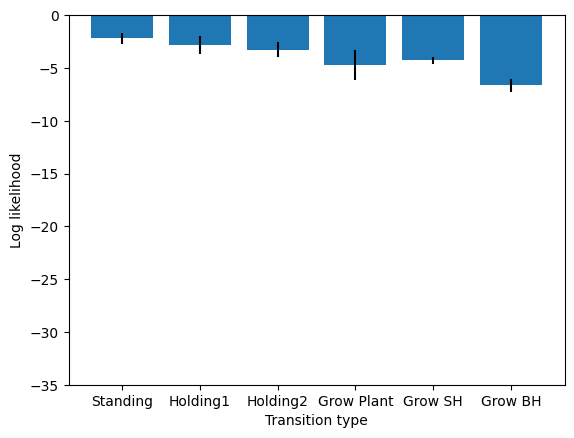

In [30]:
# Plot distribution of loglikelihood for a specific rule
index_rule = (6,-1)
algo_name = "PB"
rule = all_best_rules[algo_name][index_rule]
ll = all_best_transition_ll[algo_name][index_rule]
print(repr(rule))

# Classify per transition type
mean_values = []
std_values = []
labels = ["Standing", "Holding1", "Holding2", "Grow Plant", "Grow SH", "Grow BH"]
for transition_type, indices in dict_index_transition.items():
    mean_values.append(ll[indices].mean())
    std_values.append(ll[indices].std())
plt.figure()
plt.bar(labels, mean_values, yerr=std_values)
plt.ylabel("Log likelihood")
plt.xlabel("Transition type")
plt.ylim(-35,0)
# plt.title(f"Log likelihood for rule {repr(rule)}")
plt.show()

'- If you give the object: The objects transform into the corresponding type (action: You give the object. Change: The objects transform into the [object type]).\n- If you are standing on an object in the environment and then give the water: The object and the water in your inventory are removed (action: You are standing on the [object]. action: You give the water. Change: The objects transform into the [object type]).\n- If you pick up the object:\n  - If the object is a berry, pea, potato, beet, or water, and you pick it up: In your inventory remains the same (In your inventory, there/are the [object/objects]).\n  - If the object is a berry, pea, potato, beet, or water, and you pick it up multiple times: In your inventory remains the same'


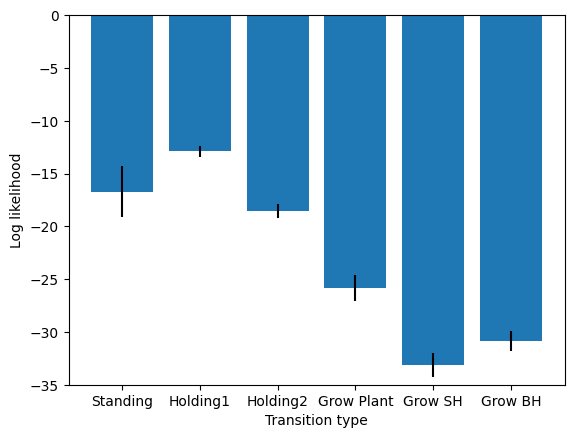

In [31]:
# Plot distribution of loglikelihood for the None rule
ll = np.array(norule_transition_likelihood_lst)[0]
print(repr(rule))

# Classify per transition type
mean_values = []
std_values = []
labels = ["Standing", "Holding1", "Holding2", "Grow Plant", "Grow SH", "Grow BH"]
for transition_type, indices in dict_index_transition.items():
    mean_values.append(ll[indices].mean())
    std_values.append(ll[indices].std())
plt.figure()
plt.bar(labels, mean_values, yerr=std_values)
plt.ylabel("Log likelihood")
plt.xlabel("Transition type")
plt.ylim(-35,0)
# plt.title(f"Log likelihood for rule {repr(rule)}")
plt.show()

## Plot relation data collected, rule generated

In [17]:
#Plot the collected transitions per episode for a specific algorithm and transition type

# plt.figure(figsize=(12,10))
# x = np.arange(transitions_per_episode_per_transition.shape[1])
# y = transitions_per_episode_per_transition.mean(axis=0)
# yerr=transitions_per_episode_per_transition.std(axis=0)
# plt.plot(x,y, label=[transition_type])
# plt.fill_between(x, y-yerr, y+yerr, alpha=0.2)
# plt.ylim(0,25)
# plt.xlabel("Number of data collection")
# plt.ylabel("Number of collected transitions per data collection")
# # plt.ylim(0,5)
# plt.legend()
# plt.show()

<Figure size 640x480 with 0 Axes>

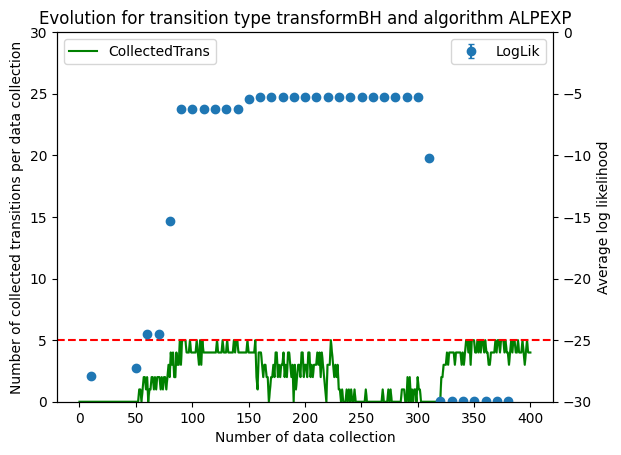

In [30]:
algo_name = "ALPEXP"
transition_type = "transformBH"
for seed in range(1):
    seed = [seed]
    # Compute evolution of collected data
    transitions_per_episode_per_transition = []
    for _seed in range(all_used_transitions[algo_name].shape[0]):
        all_values = []
        for step in range(all_used_transitions[algo_name].shape[1]):
            all_values.append(all_used_transitions[algo_name][_seed, step].get(transition_type, 0))
        transitions_per_episode_per_transition.append(all_values)
    transitions_per_episode_per_transition = np.array(transitions_per_episode_per_transition)

    ## PLot the evolution of the number of collected transitions per episode
    plt.figure()
    fig, ax1 = plt.subplots()
    x = np.arange(transitions_per_episode_per_transition.shape[1])
    y = transitions_per_episode_per_transition[seed].mean(axis=0)
    yerr=transitions_per_episode_per_transition[seed].std(axis=0)
    ax1.plot(x,y, label=["CollectedTrans"], color="g")
    ax1.fill_between(x, y-yerr, y+yerr, alpha=0.2, color="g")
    ax1.set_xlabel("Number of data collection")
    ax1.set_ylabel("Number of collected transitions per data collection")
    ax1.legend(loc='upper left')
    ax1.axhline(y=5, color='r', linestyle='--', label='y=5')
    ax1.set_ylim(0,30)
    # Compute evolution of loglikelihood of the transition for the algorithm on all seeds
    average_size = 10
    kernel = np.ones(average_size) / average_size
    ## Get the best rules for each particle and data collection for each traj type
    _ll_per_transition = all_best_transition_ll[algo_name][:,:,dict_index_transition[transition_type]].mean(axis=-1)

    ax2 = ax1.twinx()
    ## Add no rule as first collect:
    average_mean_ll = np.convolve(_ll_per_transition[seed].mean(axis=0), kernel, mode='valid')[::average_size]
    average_std_ll = np.convolve(_ll_per_transition[seed].std(axis=0), kernel, mode='valid')[::average_size]
    #Plot
    ax2.errorbar(average_size*np.arange(len(average_mean_ll))+ incr*0.05, average_mean_ll, yerr=average_std_ll, label="LogLik", capsize=2, fmt='o')
    ax2.set_xlabel("Number of data collection")
    ax2.set_ylabel("Average log likelihood")
    ax2.set_ylim(-30,0)
    ax2.legend(loc='upper right')
    plt.title(f"Evolution for transition type {transition_type} and algorithm {algo_name}")
    plt.show()

## Embeddings

In [33]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules[b_name][:, ::20].flatten() for b_name in all_baselines_name], axis=0))

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

### t-SNE

In [34]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

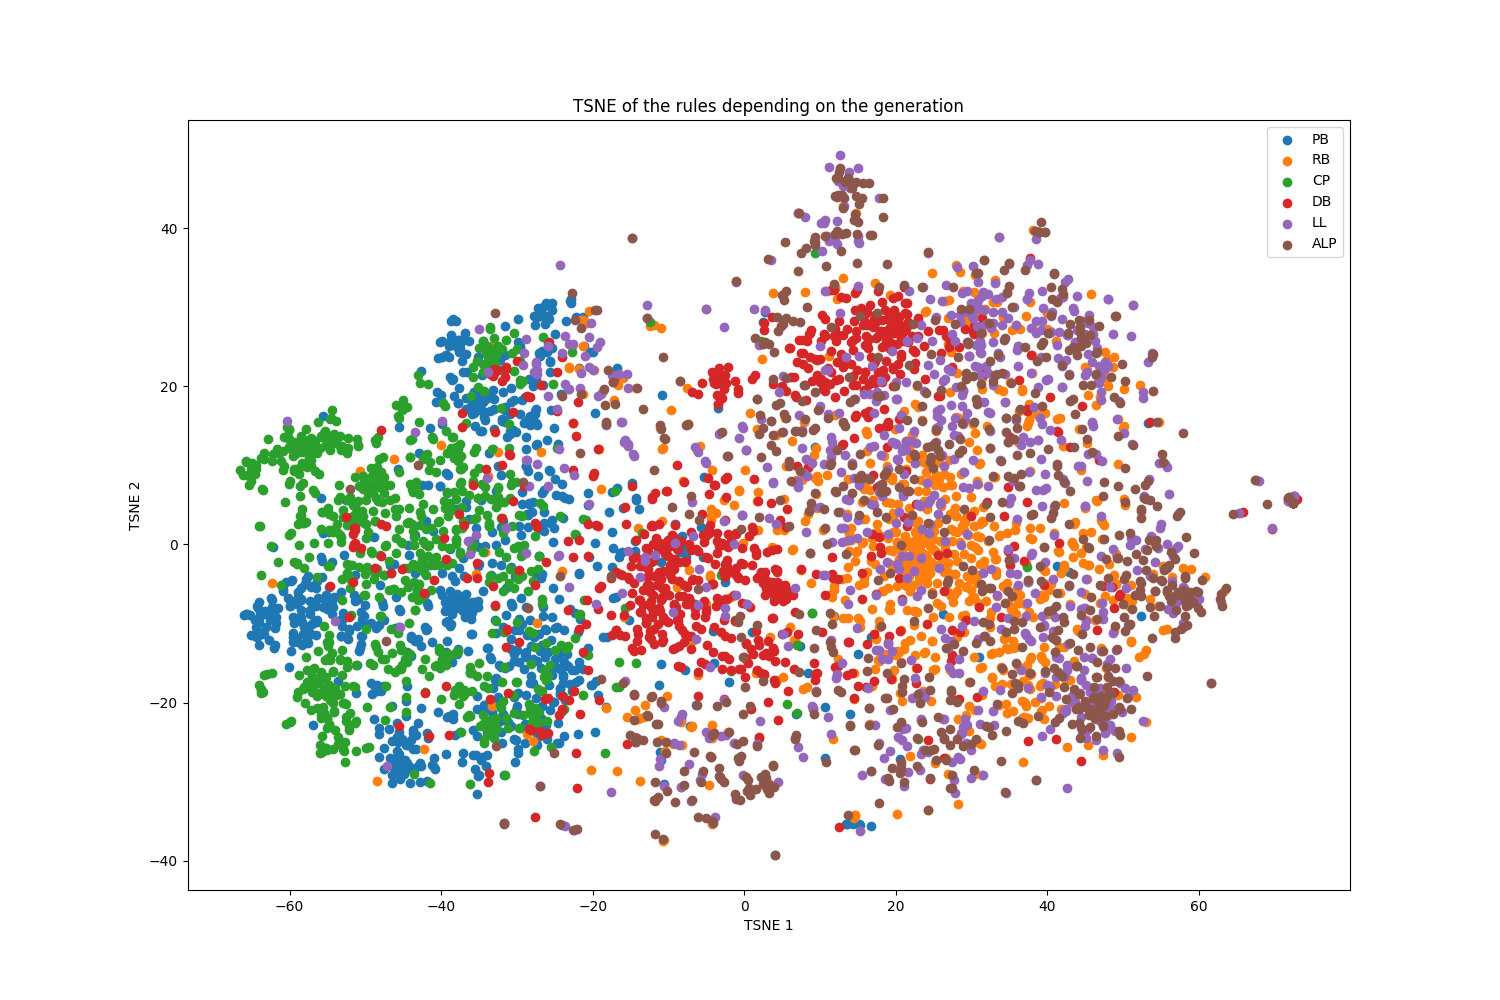

In [25]:
# Enable interactive backend
%matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name][:, ::20].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name][:, ::20].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name][:, ::20].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::20].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

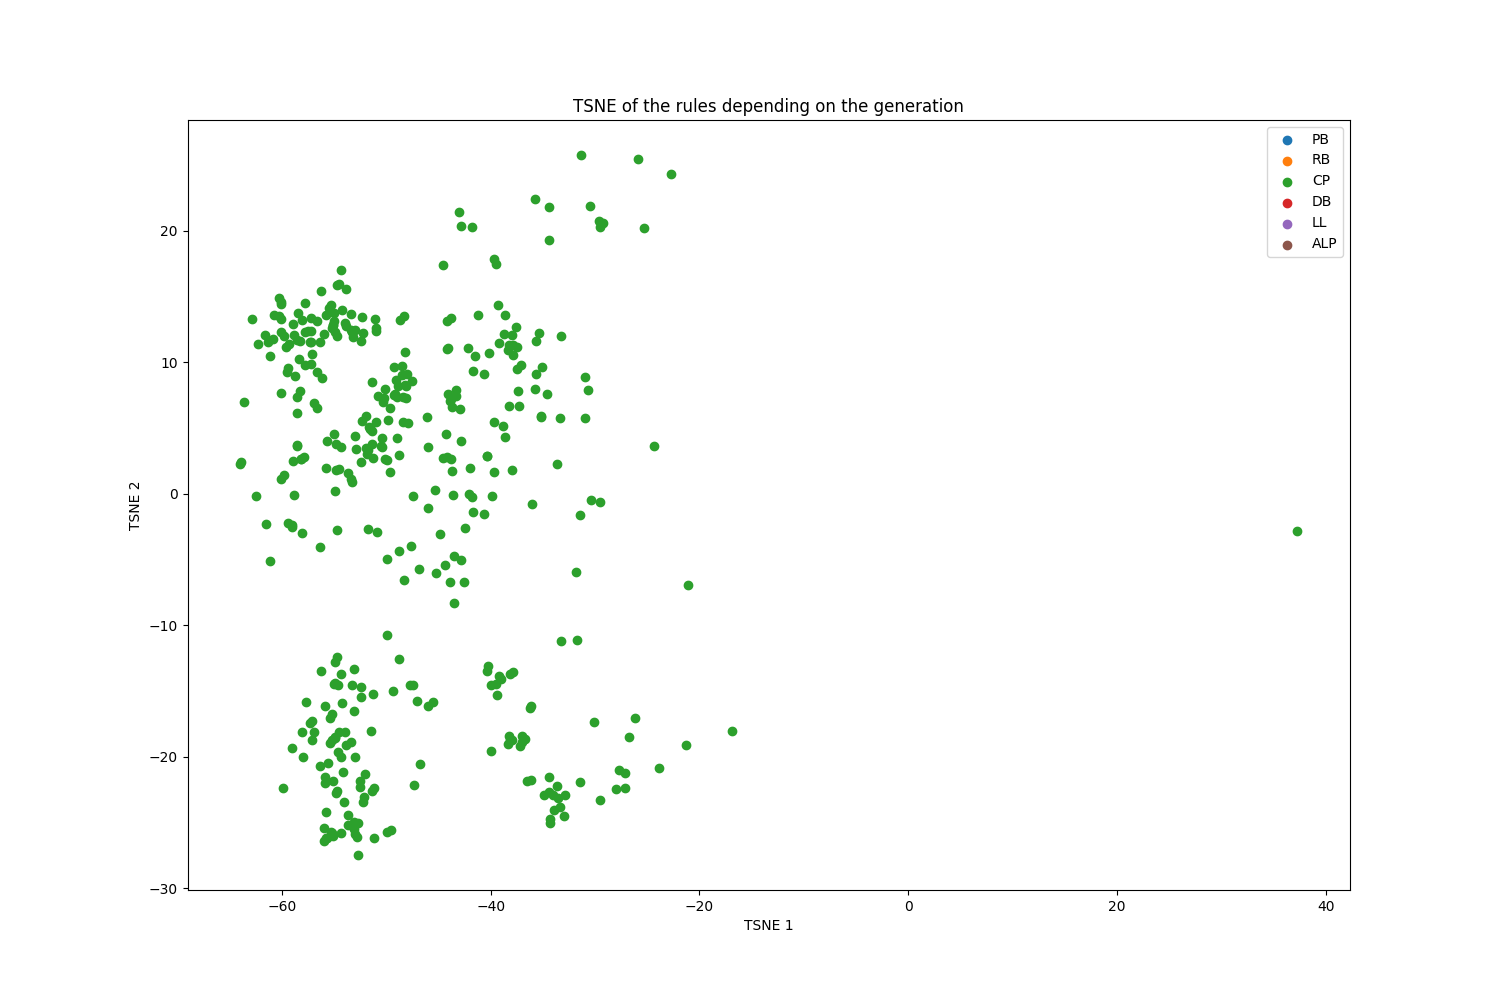

In [26]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name][:, ::20].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -700
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name][:, ::20].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::20].flatten())
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

### PCA

In [27]:
#Compute the PCA embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_embeddings = pca.fit_transform(embeddings)

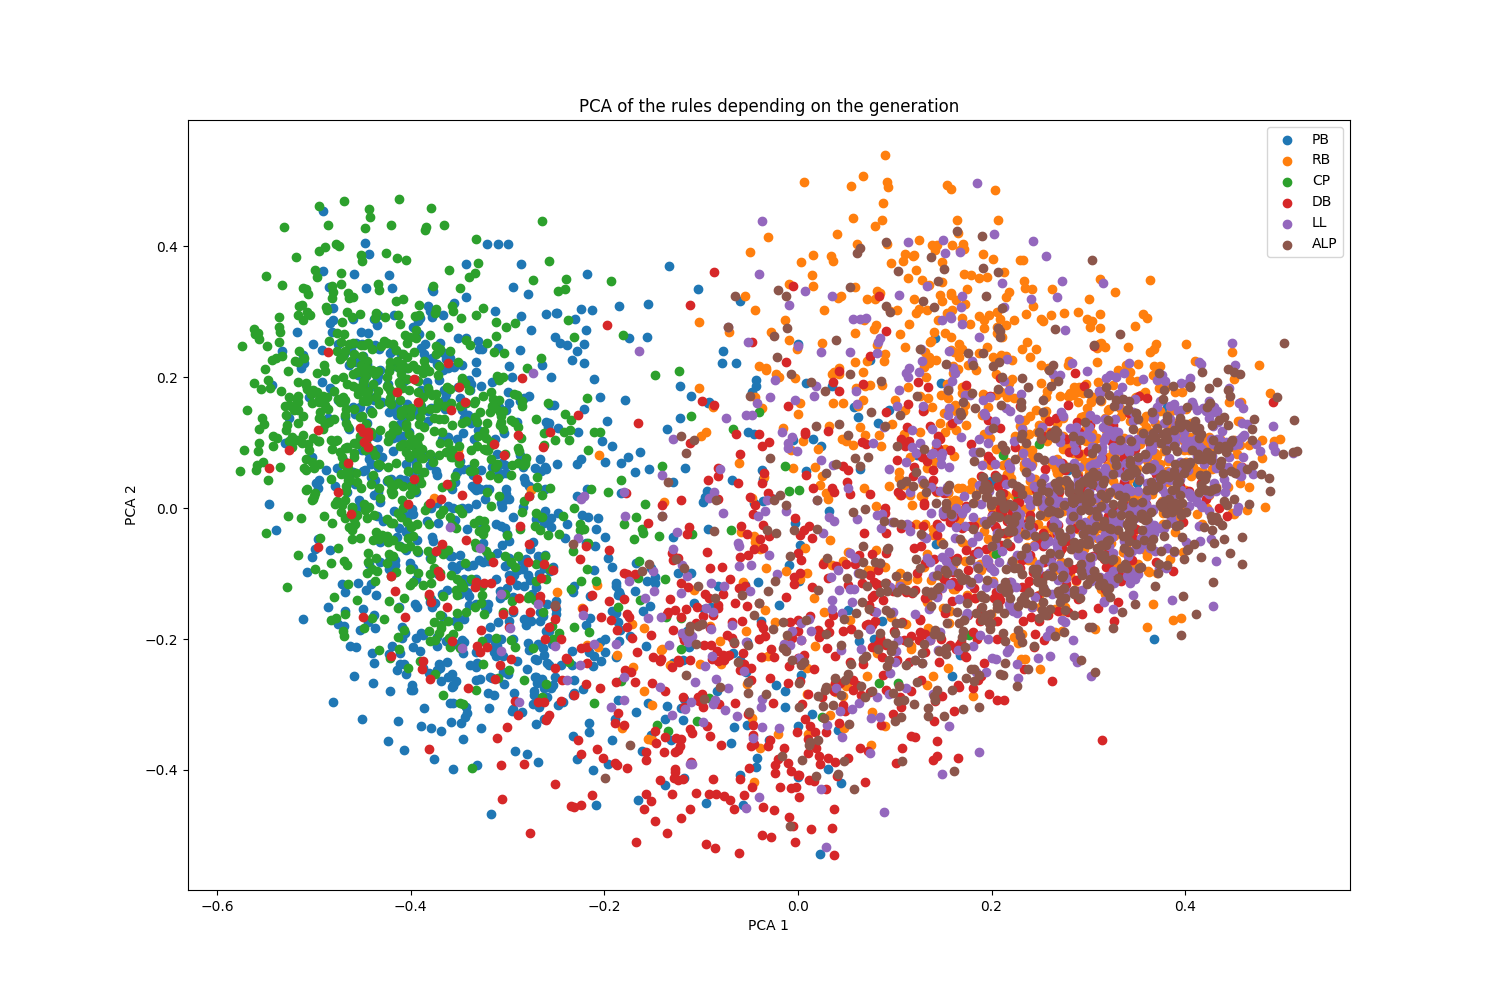

In [28]:
# # Enable interactive backend
# %matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name][:, ::20].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name][:, ::20].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name][:, ::20].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::20].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()

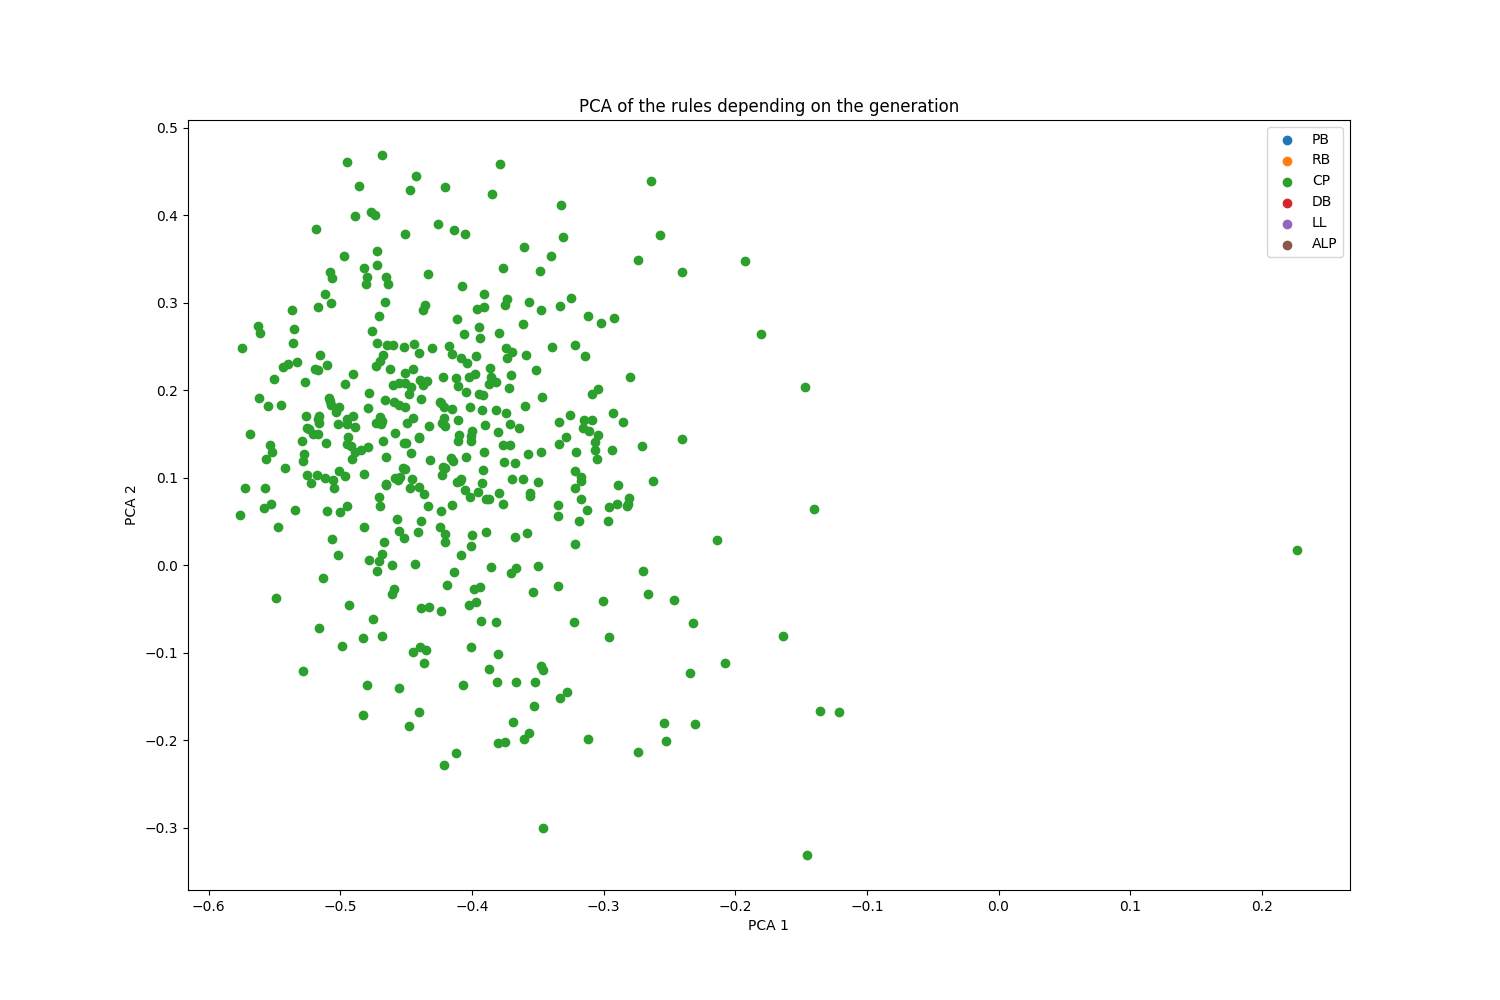

In [29]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name][:, ::20].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -720
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name][:, ::20].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::20].flatten())
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()